In [94]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.model_selection import train_test_split
from keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, Adadelta, Adamax
from keras import layers, models, Model
from keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from keras.layers import Input, Activation,MaxPooling2D, Concatenate, AveragePooling2D

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

# Regression CNN

## Table of Contents
1. [Dataset](#dataset)
2. [Load and Preprocess](#load-and-preprocess)
3. [Model Architectures](#model-architectures)
4. [Metrics](#metrics)
5. [Compile and Fit](#compile-and-fit)
6. [Experiments](#experiments)
    - [Experiment 1: TINTO](#experiment-1-tinto)
    - [Experiment 2: IGTD](#experiment-2-igtd)
    - [Experiment 3: Combination](#experiment-3-combination)
7. [Final Metrics and Best Model](#final-metrics-and-best-model)

## DATASET

In [95]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [96]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'logs/{dataset_name}/CNN_Regression'

In [97]:
df = pd.read_csv(f"../Datasets_benchmark/Regression/{dataset_name}.csv")

## LOAD AND PREPROCESS

In [98]:
from sklearn.preprocessing import MinMaxScaler
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]

    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)

    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    imgs_shape = X_train_img[0].shape

    print("Images shape: ",imgs_shape)
    print("Attributres: ",attributes)
    pixels=X_train_img[0].shape[0]
    print("Image size (pixels):", pixels)

    return X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes

## MODEL ARCHITECTURES

In [99]:
# Small CNN for regression
def create_model1(imgs_shape):
    model1 = Sequential([
        Input(shape=imgs_shape),
        Conv2D(8, (3, 3), activation='relu'),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    return model1

In [100]:
# Medium CNN
def create_model2(imgs_shape):
    model2 = Sequential([
        Input(shape=imgs_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(32, (3, 3), activation='relu'),
        
        Conv2D(64, (3, 3), activation='relu'),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    return model2

In [101]:
# CNN with 2 branches

def create_model3(cnn_input_shape):
    # CNN branch
    cnn_dropout = 0.1
    cnn_input = Input(shape=cnn_input_shape)

    # CNN branch 1
    tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(cnn_input)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    # CNN branch 2
    tower_2 = Conv2D(16, (5,5), activation='relu',padding="same")(cnn_input)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    #Concatenate CNN branches
    merged_cnn = Concatenate(axis=1)([tower_1, tower_2])

    #Flatten
    merged = Flatten()(merged_cnn)

    #Dense layers
    out = Dense(256, activation='relu')(merged)
    out = Dropout(cnn_dropout)(merged)
    out = Dense(128, activation='sigmoid')(out)
    out = Dropout(cnn_dropout)(out)
    out = Dense(64, activation='sigmoid')(out)
    out = Dropout(cnn_dropout)(out)
    out = Dense(32, activation='sigmoid')(out)
    out = Dropout(cnn_dropout)(out)
    cnn_output = Dense(1, activation='linear')(out)

    model3 = Model(cnn_input, cnn_output)

    return model3

## METRICS

In [102]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

## COMPILE AND FIT

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):

    opt = Adam(learning_rate=lr)

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Print messages when the callback takes an action
        mode='min',           # Training will stop when the quantity monitored has stopped decreasing
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    
    model.compile(
        loss="mse",
        optimizer=opt,
        metrics=METRICS
    )

    model_history = model.fit(
        x=X_train_img, y=y_train,
        validation_data=(X_val_img, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    # SAVE FIGURES
    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
    plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/loss_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
    plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/mse_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['rmse'], color = 'red', label = 'rmse')
    plt.plot(model_history.history['val_rmse'], color = 'green', label = 'val rmse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/rmse_plot.png")

    # SAVE MODEL
    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)
    model.save(f"models/{dataset_name}/{model_name}/model_{dataset_name}.keras")

    # SAVE METRICS
    # Evaluate the model on the training set
    train_scores = model.evaluate(X_train_img, y_train)

    # Evaluate the model on the validation set
    val_scores = model.evaluate(X_val_img, y_val)

    # Evaluate the model on the test set
    score_test = model.evaluate(X_test_img, y_test)

    # Save training, validation, and test scores
    metrics = {
        'train_loss': train_scores[0],
        'train_mse': train_scores[1],
        'train_mae': train_scores[2],
        'train_rmse': train_scores[3],
        'train_r2': train_scores[4],
        'val_loss': val_scores[0],
        'val_mse': val_scores[1],
        'val_mae': val_scores[2],
        'val_rmse': val_scores[3],
        'val_r2': val_scores[4],
        'test_loss': score_test[0],
        'test_mse': score_test[1],
        'test_mae': score_test[2],
        'test_rmse': score_test[3],
        'test_r2': score_test[4]
    }

    # Save metrics to a file
    os.makedirs(f'{results_path}/{model_name}', exist_ok=True)
    with open(f'{results_path}/{model_name}/{dataset_name}_metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    return metrics

In [104]:
def safe_compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            metrics = compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size, epochs, lr)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None

In [105]:
def try_create_model(create_model_func, imgs_shape):
    try:
        model = create_model_func(imgs_shape)
        return model
    except Exception as e:
        print(f"Error creating {create_model_func.__name__}: {str(e)}")
        return None

## EXPERIMENTS

In [106]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_IGTD"

Default the seed is 1 for all experiments

### EXPERIMENT 1: TINTO

In [107]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [108]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/boston/images_boston_TINTO_blur\regression.csv
Images shape:  (20, 20, 3)
Attributres:  13
Image size (pixels): 20


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4360.3477 - mae: 54.7549 - mse: 4360.3477 - r_square: -97.8805 - rmse: 64.6758 - val_loss: 843.6115 - val_mae: 28.0331 - val_mse: 843.6115 - val_r_square: -17.5878 - val_rmse: 29.0450
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 437.7315 - mae: 17.6038 - mse: 437.7315 - r_square: -4.9416 - rmse: 20.4535 - val_loss: 53.9784 - val_mae: 5.8021 - val_mse: 53.9784 - val_r_square: 0.0630 - val_rmse: 7.3470
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.5713 - mae: 7.3483 - mse: 99.5713 - r_square: -0.4562 - rmse: 9.9386 - val_loss: 118.7708 - val_mae: 9.4759 - val_mse: 118.7708 - val_r_square: -1.4139 - val_rmse: 10.8982
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114.4679 - mae: 8.8958 - mse: 114.4679 - r_square: -0.8098 - rmse: 10.6815 - val_loss: 46.4381 - val_mae: 5.3008 - val_mse: 46.4381 - val_r_square: 0.2173 - val_rmse: 6.8145
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

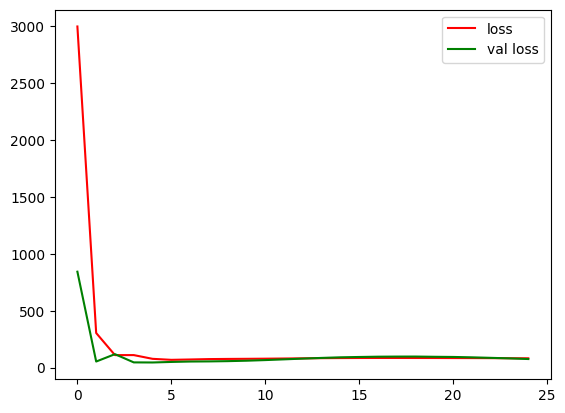

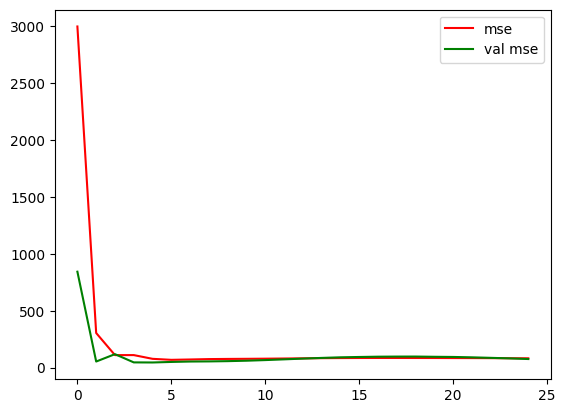

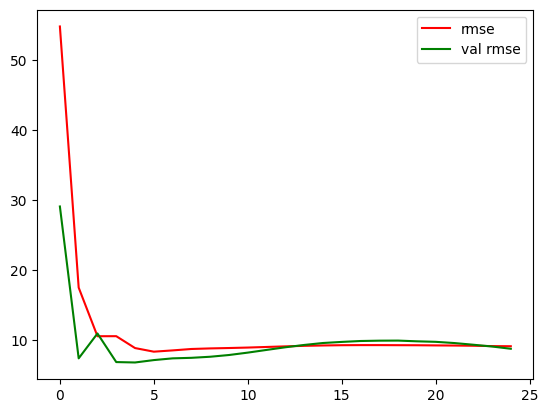

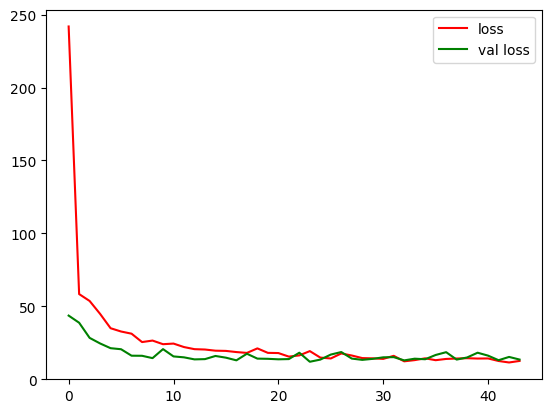

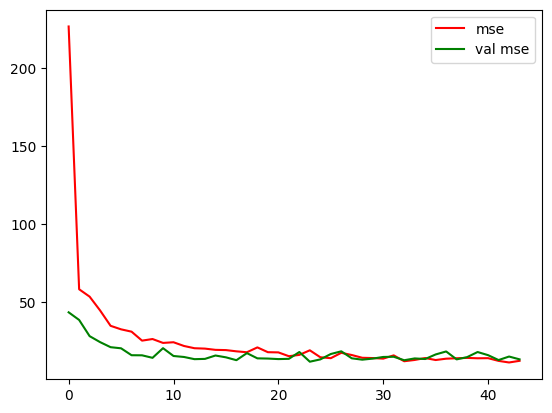

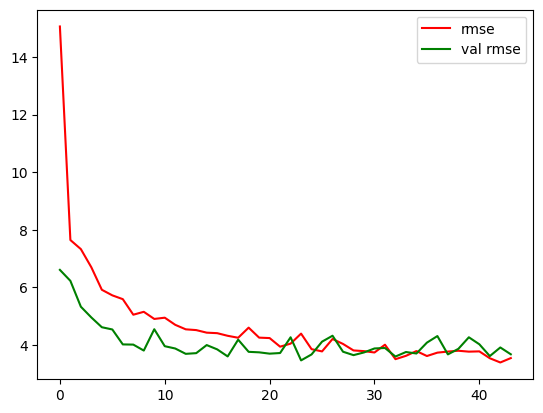

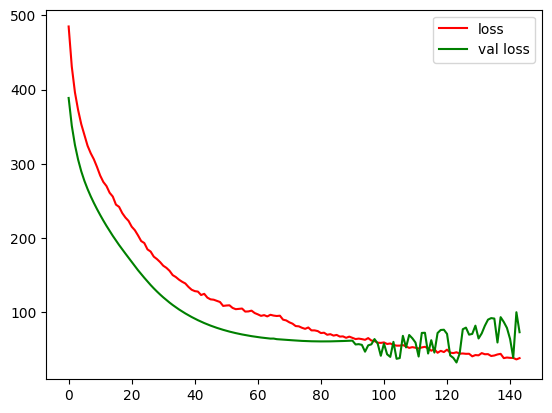

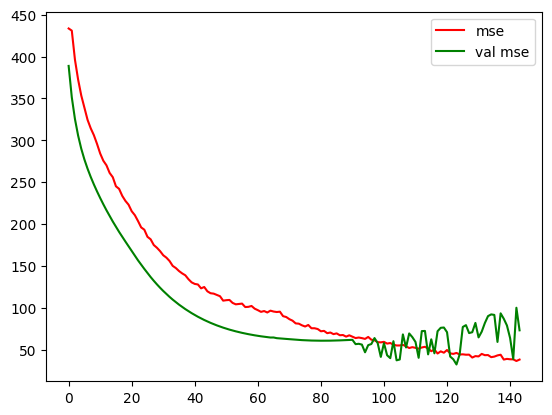

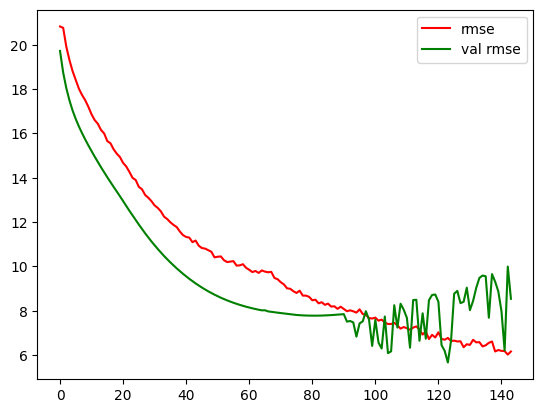

In [109]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [110]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [111]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_TINTO\regression.csv
Images shape:  (20, 20, 3)
Attributres:  13
Image size (pixels): 20


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 898.4493 - mae: 18.2554 - mse: 620.7768 - r_square: -11.4696 - rmse: 24.5261 - val_loss: 65.7587 - val_mae: 5.8733 - val_mse: 65.7587 - val_r_square: -0.2928 - val_rmse: 8.1092
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69.6580 - mae: 5.9229 - mse: 69.6580 - r_square: 0.0995 - rmse: 8.3055 - val_loss: 51.5195 - val_mae: 5.9222 - val_mse: 51.5195 - val_r_square: -0.0068 - val_rmse: 7.1777
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.6262 - mae: 5.7160 - mse: 61.6262 - r_square: 0.1534 - rmse: 7.8312 - val_loss: 55.9380 - val_mae: 6.3138 - val_mse: 55.9380 - val_r_square: -0.1126 - val_rmse: 7.4792
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.9248 - mae: 6.1311 - mse: 64.9248 - r_square: 0.0535 - rmse: 8.0479 - val_loss: 57.9309 - val_mae: 6.4269 - val_mse: 57.9309 - val_r_square: -0.1659 - val_rmse: 7.6112
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.5610 - mae:

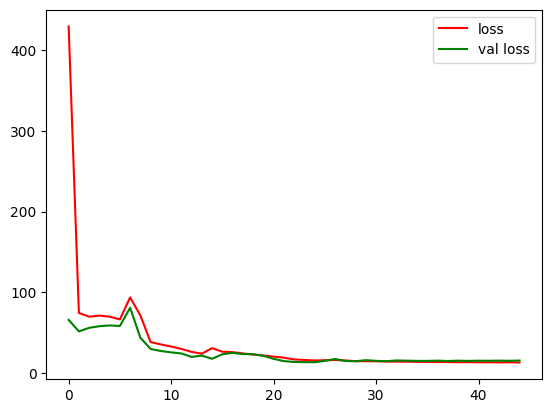

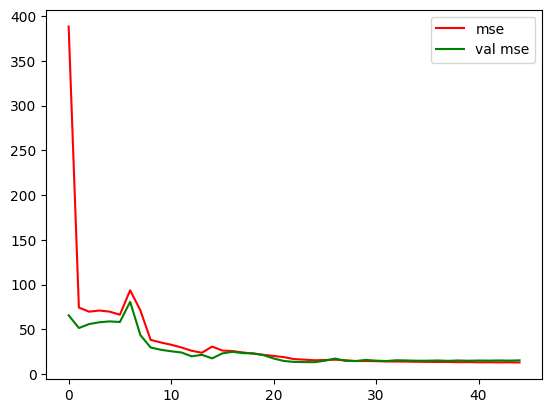

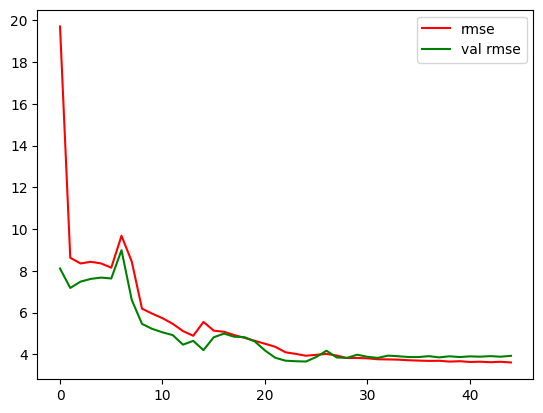

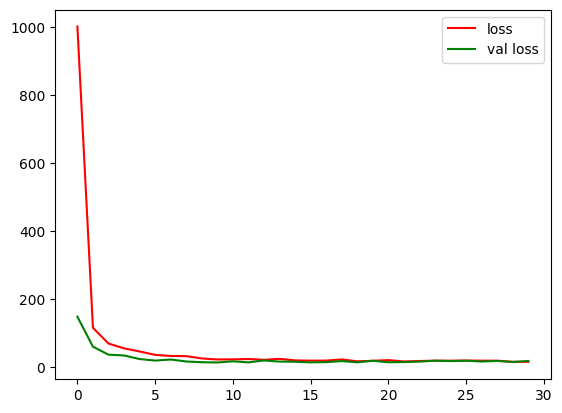

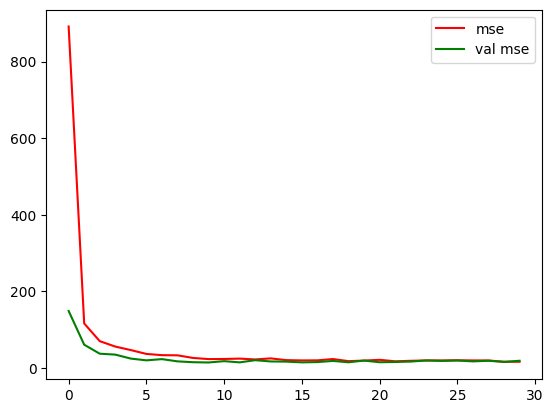

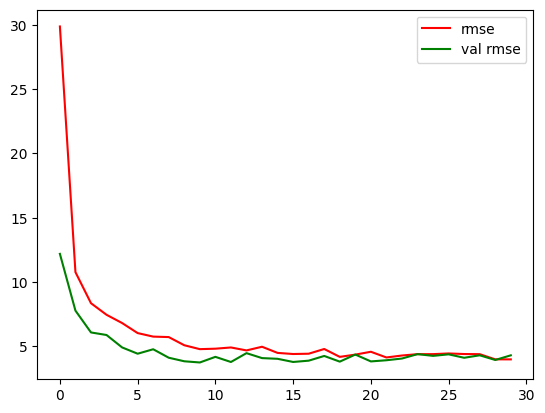

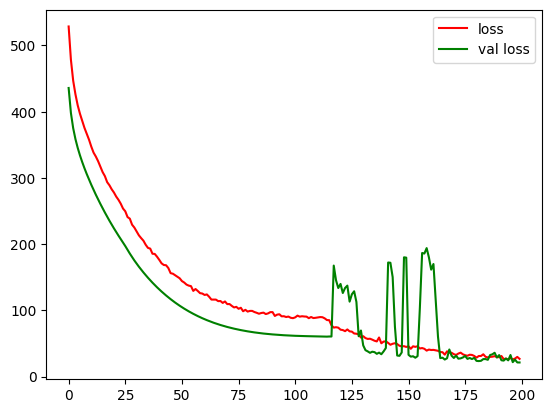

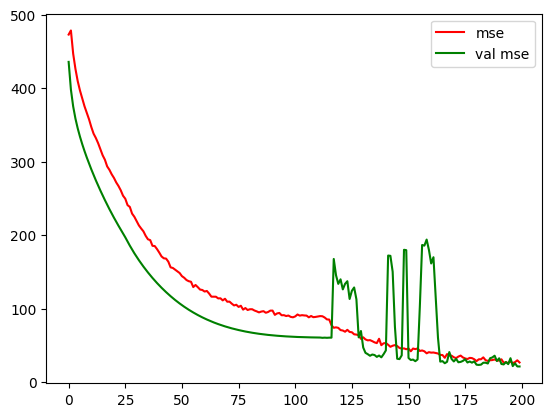

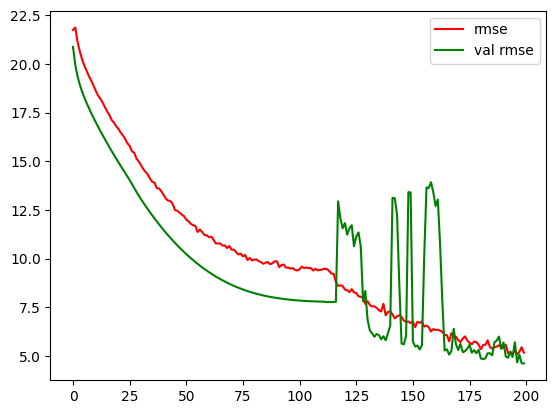

In [112]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 2: IGTD

In [39]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [40]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size])
name = f"IGTD_{image_size}x{image_size}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [41]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_IGTD_4x4\regression.csv
Images shape:  (4, 4, 3)
Attributres:  13
Image size (pixels): 4


Error creating create_model2: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 16)`, `kernel shape=(3, 3, 16, 32)`, `dilation_rate=[1 1]`.
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2525.1460 - mae: 31.6135 - mse: 1834.7743 - r_square: -39.7757 - rmse: 42.7388 - val_loss: 722.2968 - val_mae: 21.5929 - val_mse: 722.2968 - val_r_square: -13.2573 - val_rmse: 26.8756
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 917.1282 - mae: 23.6101 - mse: 917.1282 - r_square: -13.3951 - rmse: 30.0970 - val_loss: 587.2651 - val_mae: 20.4815 - val_mse: 587.2651 - val_r_square: -12.1865 - val_rmse: 24.2336
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 537.0117 - mae: 18.2473 - mse: 537.0117 - r_square: -7.7937 - rmse: 23.1034 - val_loss: 272.4275 - val_mae: 12.5975 - val_mse: 272.4275 - val_r_square: -4.2219 - val_rmse: 16.5054
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 325.9882 - mae: 13.0602 - mse: 325.9882 - r_square:

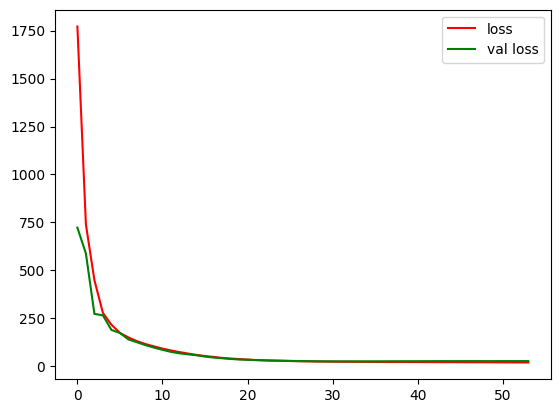

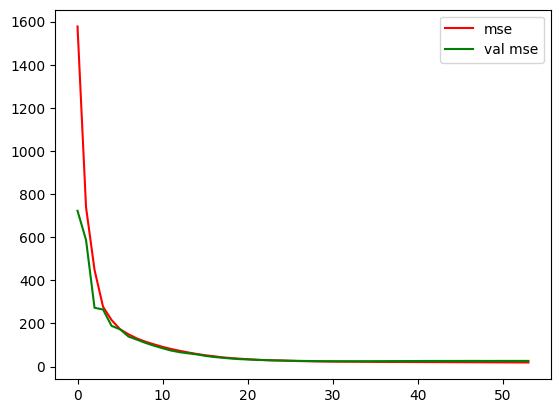

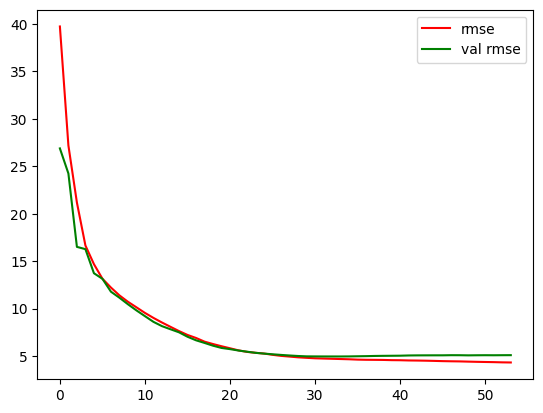

In [42]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [43]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], zoom=2)
name = f"IGTD_{image_size*2}x{image_size*2}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [44]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_IGTD_8x8\regression.csv
Images shape:  (8, 8, 3)
Attributres:  13
Image size (pixels): 8


Error creating create_model2: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 32)`, `kernel shape=(3, 3, 32, 64)`, `dilation_rate=[1 1]`.
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 181.5435 - mae: 9.1975 - mse: 144.9798 - r_square: -2.0266 - rmse: 12.0226 - val_loss: 94.3506 - val_mae: 7.9617 - val_mse: 94.3506 - val_r_square: -1.3220 - val_rmse: 9.7134
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113.5782 - mae: 8.3189 - mse: 113.5782 - r_square: -0.7858 - rmse: 10.5879 - val_loss: 46.6452 - val_mae: 5.1203 - val_mse: 46.6452 - val_r_square: 0.1447 - val_rmse: 6.8297
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.8721 - mae: 5.4379 - mse: 48.8721 - r_square: 0.1922 - rmse: 6.9876 - val_loss: 24.0310 - val_mae: 3.8269 - val_mse: 24.0310 - val_r_square: 0.4646 - val_rmse: 4.9021
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.2461 - mae: 4.6172 - mse: 38.2461 - r_square: 0.3919 - rmse: 6.1834 - val_l

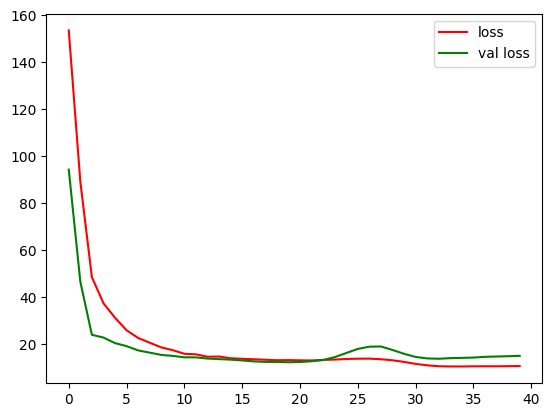

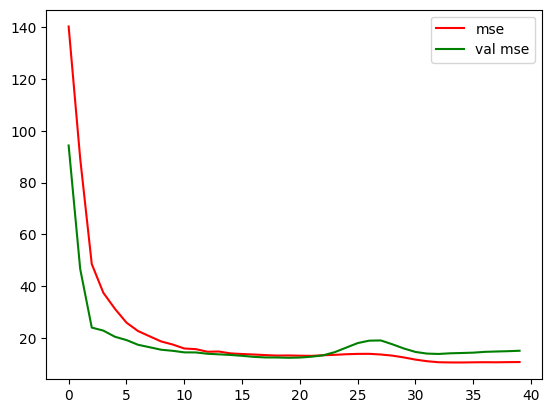

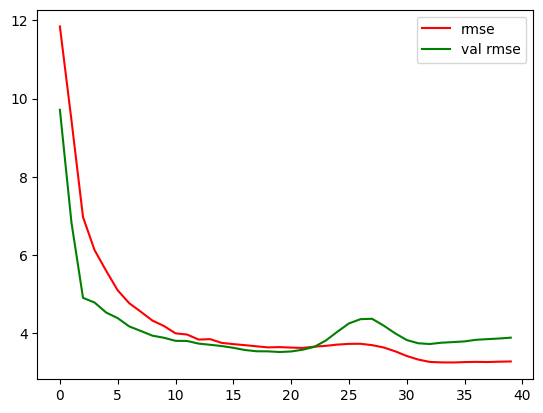

In [45]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [46]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], zoom=4)
name = f"IGTD_{image_size*4}x{image_size*4}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [47]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_IGTD_16x16\regression.csv
Images shape:  (16, 16, 3)
Attributres:  13
Image size (pixels): 16


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7945.6118 - mae: 55.3561 - mse: 5878.8091 - r_square: -166.3756 - rmse: 75.8150 - val_loss: 1087.8574 - val_mae: 27.9392 - val_mse: 1087.8574 - val_r_square: -21.7215 - val_rmse: 32.9827
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 576.7119 - mae: 17.8656 - mse: 576.7119 - r_square: -8.2428 - rmse: 23.5472 - val_loss: 98.8151 - val_mae: 7.9563 - val_mse: 98.8151 - val_r_square: -0.8563 - val_rmse: 9.9406
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87.8550 - mae: 7.5847 - mse: 87.8550 - r_square: -0.3308 - rmse: 9.3540 - val_loss: 48.5095 - val_mae: 5.1260 - val_mse: 48.5095 - val_r_square: 0.1305 - val_rmse: 6.9649
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.8358 - mae: 5.0680 - mse: 52.8358 - r_square: 0.3153 - rmse: 7.2315 - val_loss: 43.9307 - val_mae: 5.2776 - val_mse: 43.9307 - val_r_square: 0.1417 - val_rmse: 6.6280
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

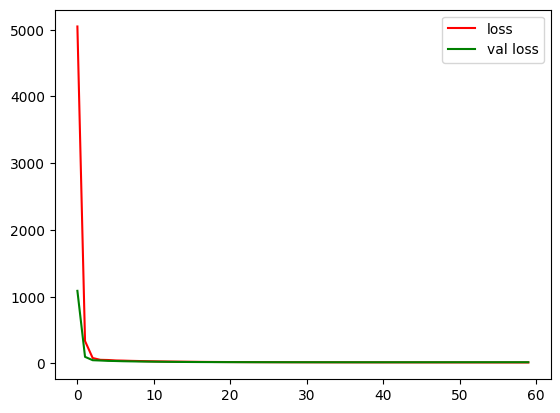

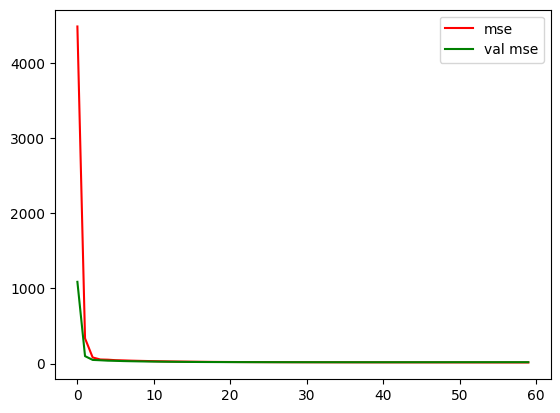

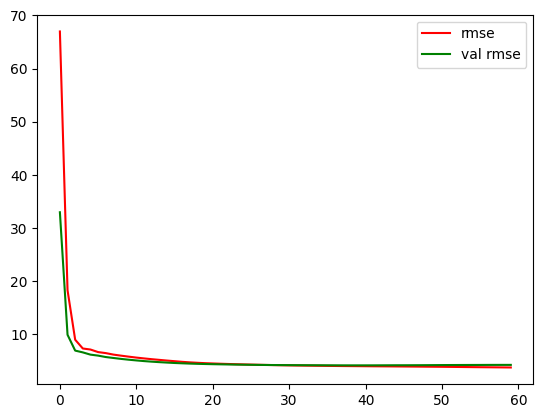

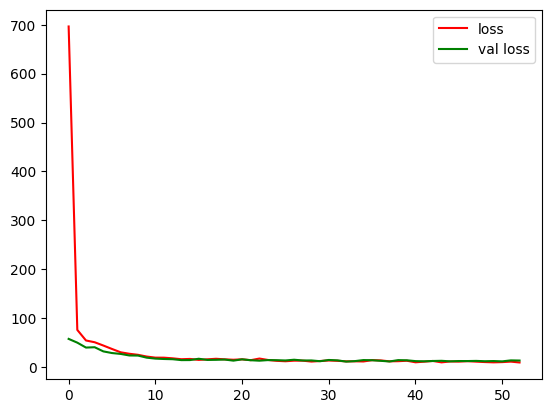

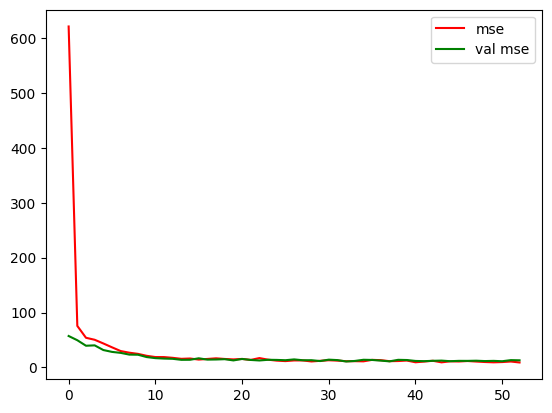

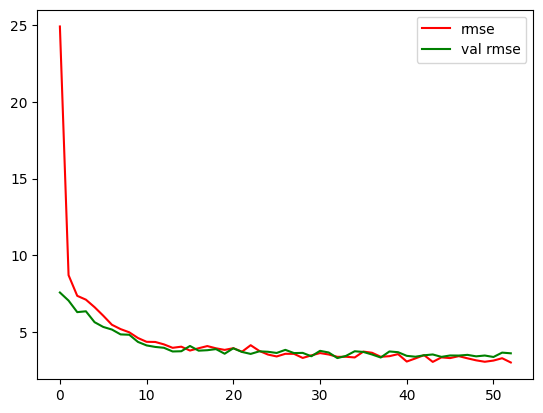

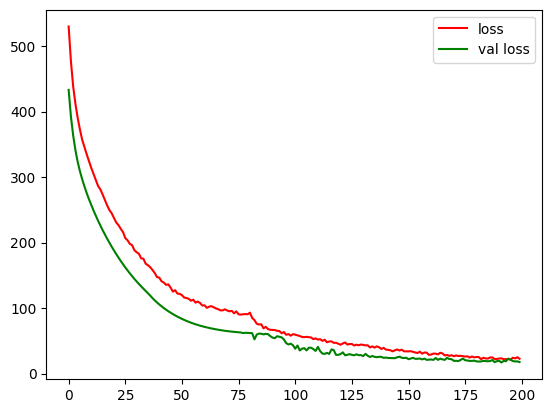

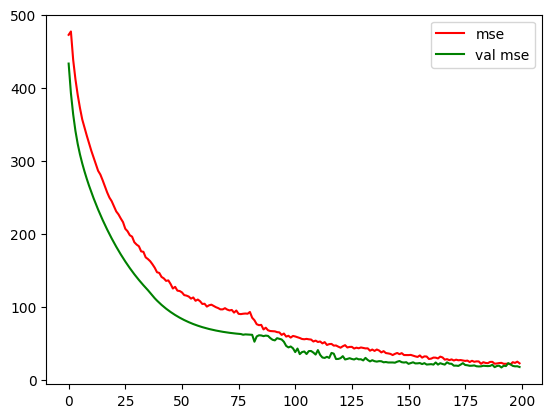

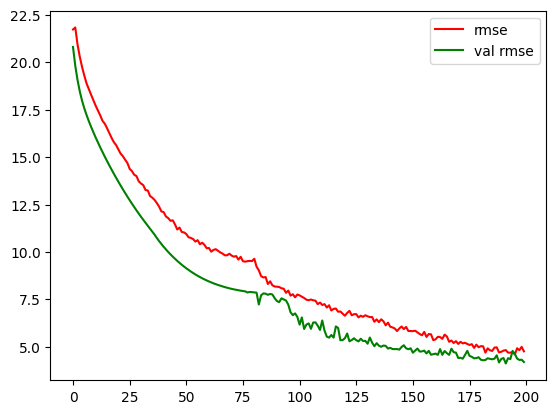

In [48]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [49]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean')
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [50]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean\regression.csv
Images shape:  (4, 4, 3)
Attributres:  13
Image size (pixels): 4


Error creating create_model2: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 16)`, `kernel shape=(3, 3, 16, 32)`, `dilation_rate=[1 1]`.
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2107.1855 - mae: 27.7693 - mse: 1519.6166 - r_square: -29.9404 - rmse: 38.9474 - val_loss: 654.0735 - val_mae: 21.5726 - val_mse: 654.0735 - val_r_square: -10.9470 - val_rmse: 25.5749
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 654.4908 - mae: 20.6029 - mse: 654.4908 - r_square: -9.1386 - rmse: 25.5587 - val_loss: 321.2539 - val_mae: 14.4073 - val_mse: 321.2539 - val_r_square: -4.4395 - val_rmse: 17.9236
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 362.5100 - mae: 15.4403 - mse: 362.5100 - r_square: -4.6776 - rmse: 19.0263 - val_loss: 178.2942 - val_mae: 10.4611 - val_mse: 178.2942 - val_r_square: -2.0915 - val_rmse: 13.3527
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 216.9424 - mae: 10.7550 - mse: 216.9424 - r_square: -

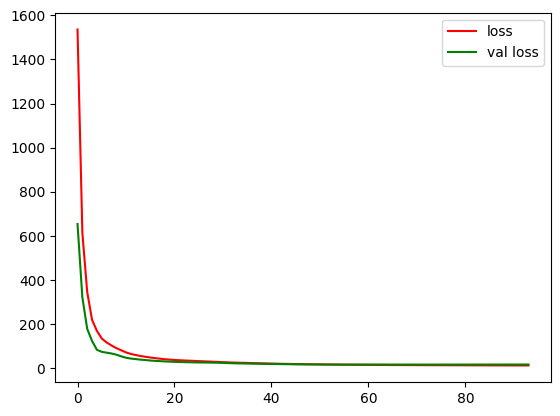

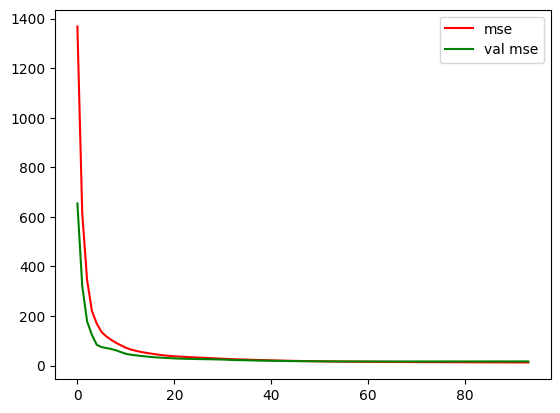

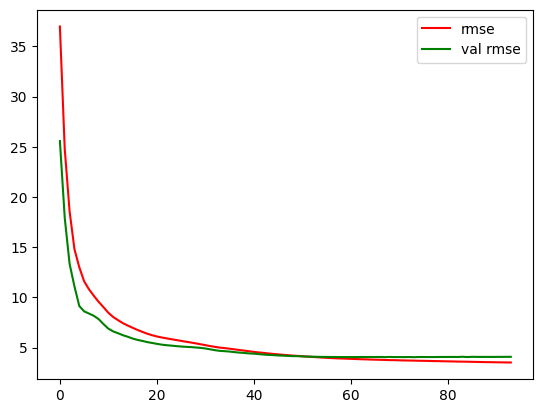

In [51]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 3: REFINED

In [52]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [53]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_REFINED\regression.csv
Images shape:  (4, 4, 3)
Attributres:  13
Image size (pixels): 4


Error creating create_model2: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 16)`, `kernel shape=(3, 3, 16, 32)`, `dilation_rate=[1 1]`.
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8459.6934 - mae: 67.7045 - mse: 6198.6646 - r_square: -137.0772 - rmse: 78.5921 - val_loss: 1567.4193 - val_mae: 38.9260 - val_mse: 1567.4193 - val_r_square: -33.4036 - val_rmse: 39.5906
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1033.3601 - mae: 29.9341 - mse: 1033.3601 - r_square: -15.0370 - rmse: 31.7678 - val_loss: 91.6381 - val_mae: 7.2026 - val_mse: 91.6381 - val_r_square: -0.7841 - val_rmse: 9.5728
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90.5625 - mae: 7.1186 - mse: 90.5625 - r_square: -0.1467 - rmse: 9.4381 - val_loss: 101.4361 - val_mae: 9.0213 - val_mse: 101.4361 - val_r_square: -1.1798 - val_rmse: 10.0716
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121.3463 - mae: 9.4588 - mse: 121.3463 - r_square: -1.03

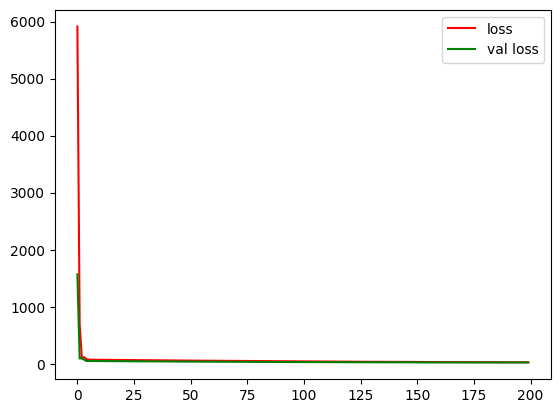

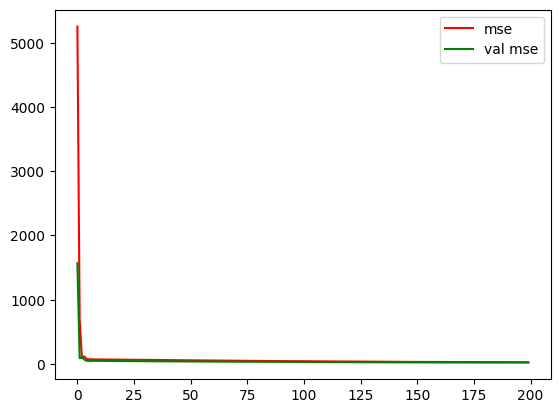

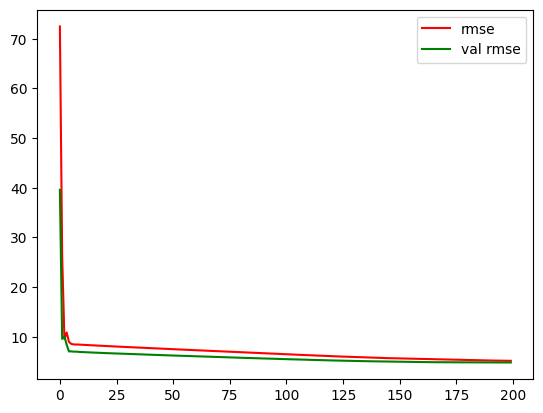

In [54]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

In [ ]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

In [ ]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 4: BAR GRAPH

In [55]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [56]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_BarGraph\regression.csv
Images shape:  (13, 13, 3)
Attributres:  13
Image size (pixels): 13


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1233.3527 - mae: 21.4795 - mse: 899.8120 - r_square: -17.5122 - rmse: 29.9408 - val_loss: 355.6121 - val_mae: 15.6991 - val_mse: 355.6121 - val_r_square: -5.0177 - val_rmse: 18.8577
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 252.4641 - mae: 12.4262 - mse: 252.4641 - r_square: -3.1311 - rmse: 15.8274 - val_loss: 92.8235 - val_mae: 8.2600 - val_mse: 92.8235 - val_r_square: -1.1273 - val_rmse: 9.6345
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.5166 - mae: 7.2947 - mse: 100.5166 - r_square: -0.5359 - rmse: 9.9259 - val_loss: 61.4462 - val_mae: 6.2846 - val_mse: 61.4462 - val_r_square: -0.5861 - val_rmse: 7.8388
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.5989 - mae: 5.3750 - mse: 49.5989 - r_square: 0.2430 - rmse: 7.0310 - val_loss: 39.7648 - val_mae: 4.8114 - val_mse: 39.7648 - val_r_square: -0.0235 - val_rmse: 6.3059
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3

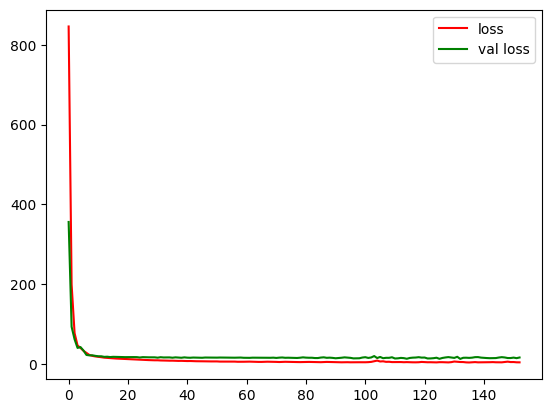

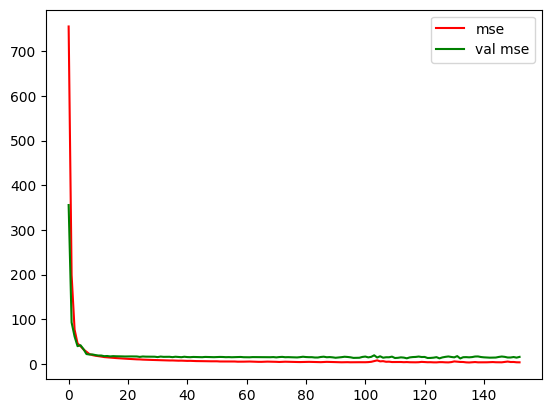

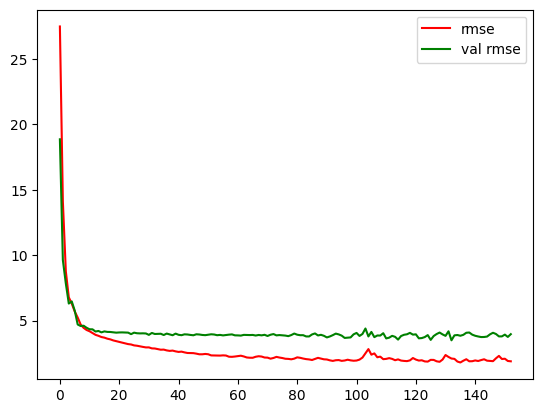

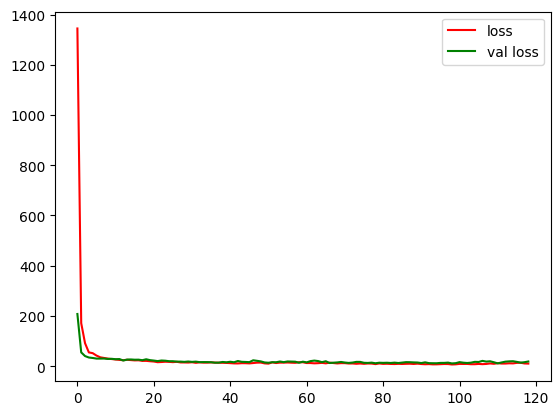

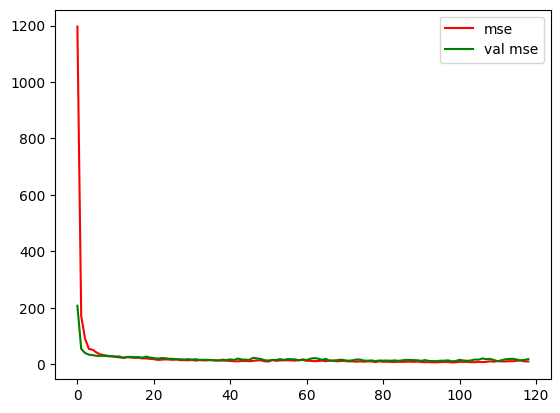

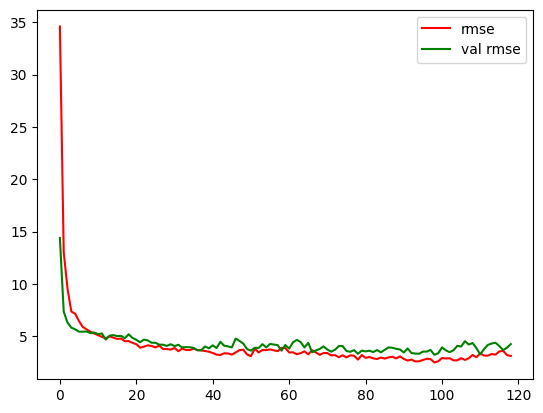

In [57]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [58]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [59]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_BarGraph_zoom2\regression.csv
Images shape:  (26, 26, 3)
Attributres:  13
Image size (pixels): 26


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 59634.9805 - mae: 119.9794 - mse: 43993.7695 - r_square: -1452.8779 - rmse: 201.9252 - val_loss: 2519.8135 - val_mae: 41.0817 - val_mse: 2519.8135 - val_r_square: -55.2954 - val_rmse: 50.1977
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1425.5167 - mae: 30.3669 - mse: 1425.5167 - r_square: -21.0128 - rmse: 37.4863 - val_loss: 686.5507 - val_mae: 21.3642 - val_mse: 686.5508 - val_r_square: -15.5315 - val_rmse: 26.2021
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 514.7759 - mae: 19.0924 - mse: 514.7759 - r_square: -7.8258 - rmse: 22.5776 - val_loss: 209.9284 - val_mae: 11.4176 - val_mse: 209.9284 - val_r_square: -4.2072 - val_rmse: 14.4889
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 193.7807 - mae: 11.0075 - mse: 193.7807 - r_square: -2.3859 - rmse: 13.9141 - val_loss: 181.7194 - val_mae: 10.8800 - val_mse: 181.7194 - val_r_square: -3.0951 - val_rmse: 13.4803
Epoch 5/200
13/13 ━━━━━━━━━

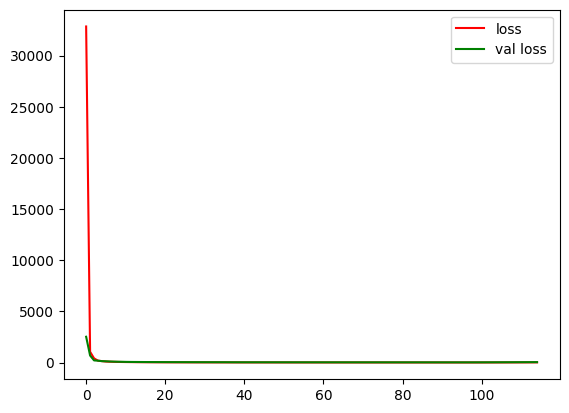

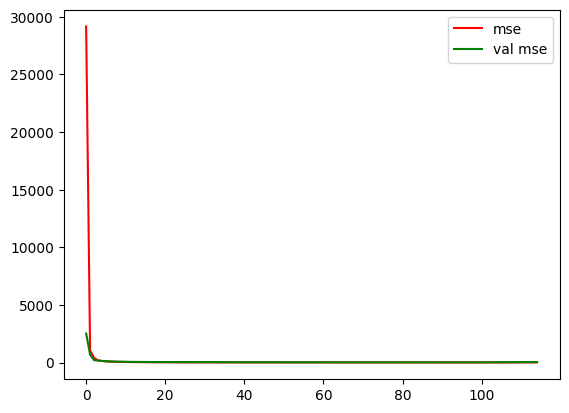

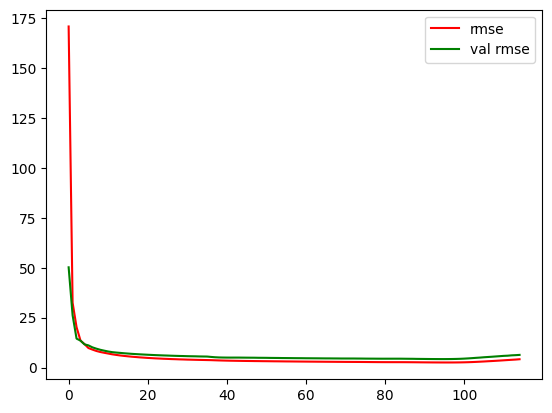

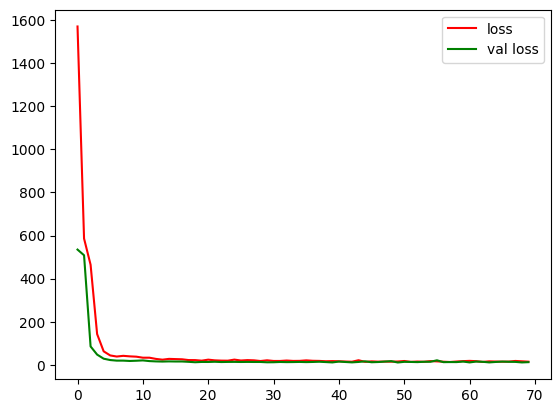

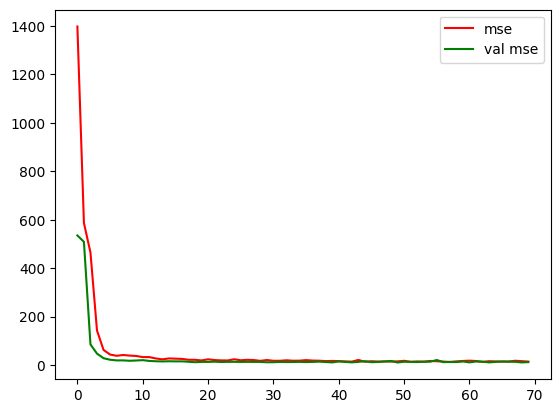

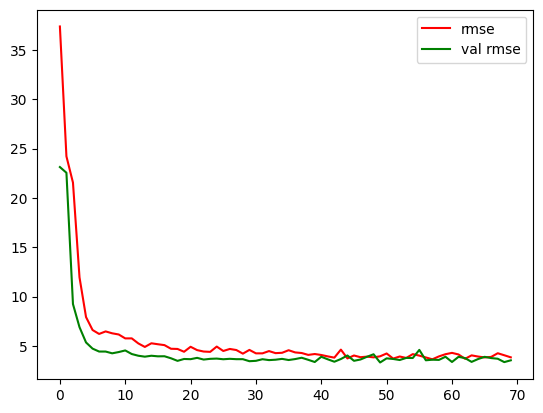

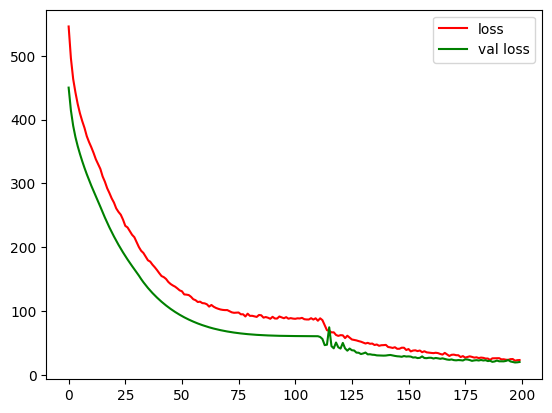

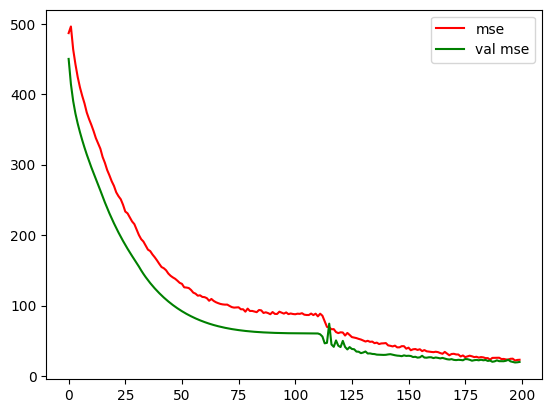

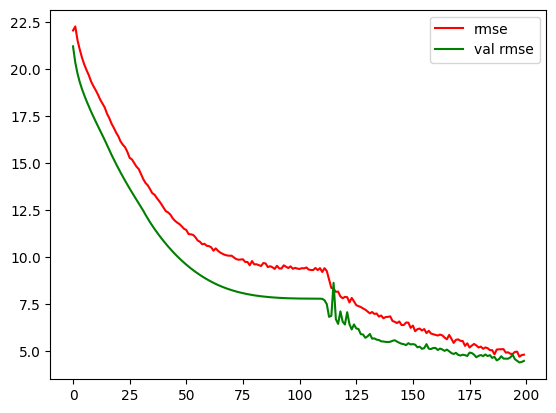

In [60]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [61]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [62]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_BarGraph_zoom4\regression.csv
Images shape:  (52, 52, 3)
Attributres:  13
Image size (pixels): 52


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 153887.9375 - mae: 210.5038 - mse: 117539.0938 - r_square: -3451.0352 - rmse: 331.7147 - val_loss: 522.0922 - val_mae: 21.4836 - val_mse: 522.0922 - val_r_square: -10.1294 - val_rmse: 22.8493
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 580.6899 - mae: 22.1895 - mse: 580.6899 - r_square: -7.8179 - rmse: 24.0722 - val_loss: 522.1252 - val_mae: 21.4844 - val_mse: 522.1252 - val_r_square: -10.1301 - val_rmse: 22.8501
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.9331 - mae: 22.0350 - mse: 561.9331 - r_square: -7.6486 - rmse: 23.6897 - val_loss: 522.0789 - val_mae: 21.4833 - val_mse: 522.0789 - val_r_square: -10.1291 - val_rmse: 22.8490
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.8759 - mae: 22.0337 - mse: 561.8759 - r_square: -7.6476 - rmse: 23.6885 - val_loss: 522.0010 - val_mae: 21.4815 - val_mse: 522.0010 - val_r_square: -10.1274 - val_rmse: 22.8473
Epoch 5/200
13/13 ━━━━━━━━━━

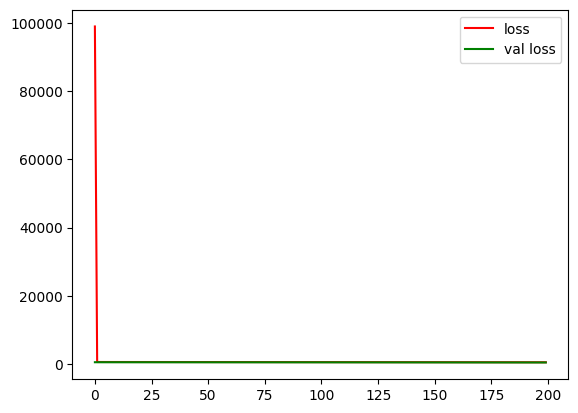

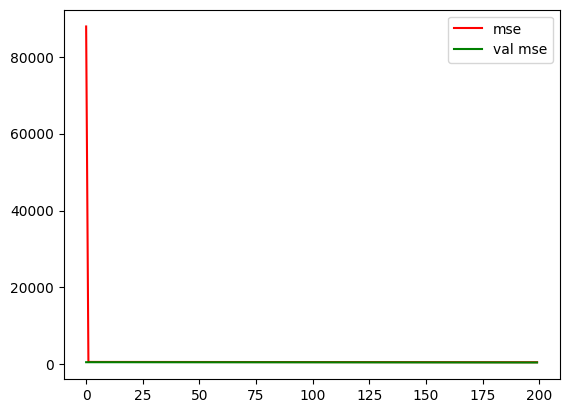

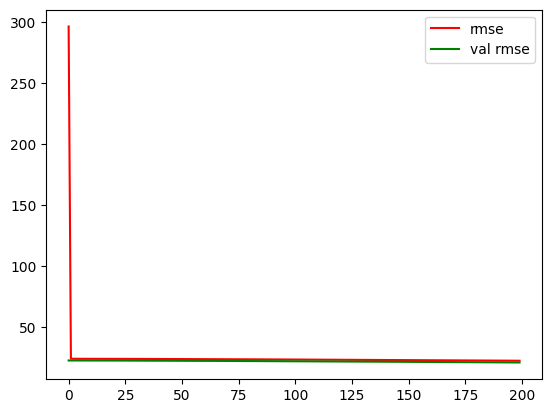

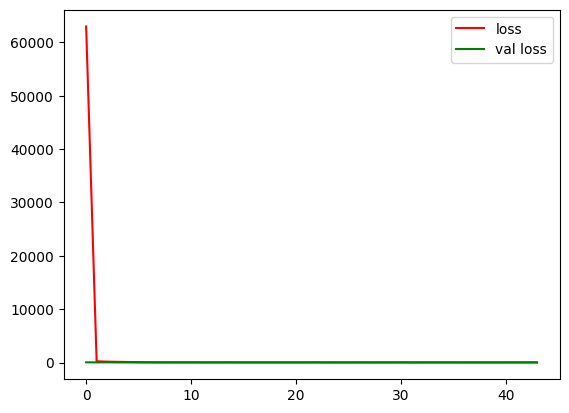

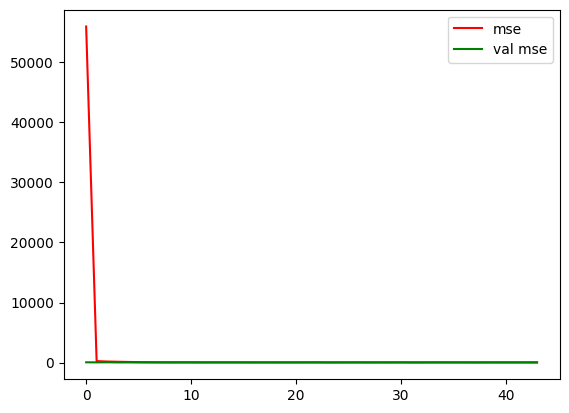

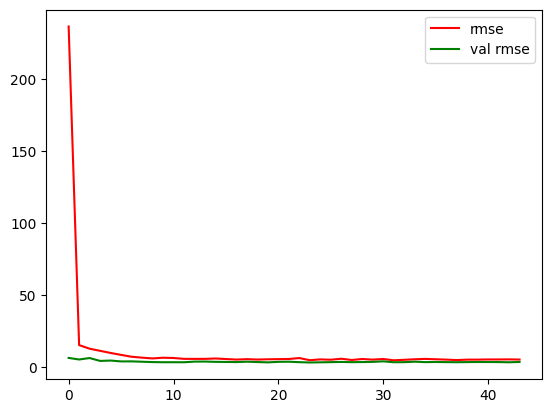

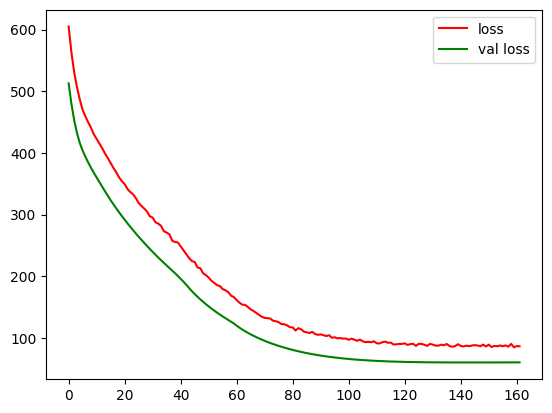

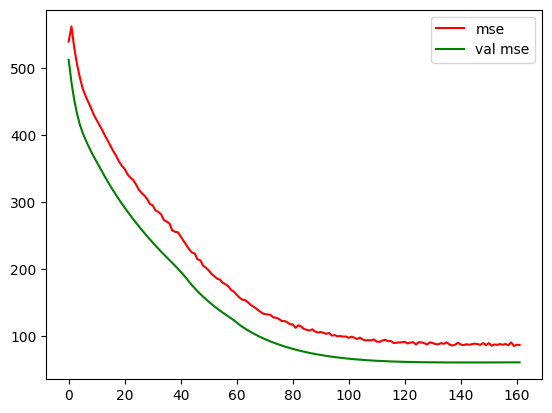

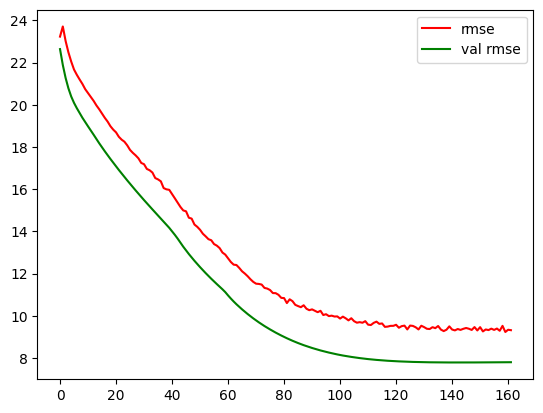

In [63]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 5: DISTANCE MATRIX

In [64]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [65]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_DistanceMatrix\regression.csv
Images shape:  (13, 13, 3)
Attributres:  13
Image size (pixels): 13


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2906.7578 - mae: 30.2526 - mse: 1936.7281 - r_square: -31.8981 - rmse: 43.1981 - val_loss: 201.1482 - val_mae: 10.3570 - val_mse: 201.1482 - val_r_square: -3.2580 - val_rmse: 14.1827
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 254.4433 - mae: 12.1778 - mse: 254.4433 - r_square: -3.5093 - rmse: 15.9124 - val_loss: 105.2932 - val_mae: 8.3462 - val_mse: 105.2932 - val_r_square: -1.2011 - val_rmse: 10.2612
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119.5771 - mae: 8.7270 - mse: 119.5771 - r_square: -0.9841 - rmse: 10.9159 - val_loss: 93.0554 - val_mae: 8.3611 - val_mse: 93.0554 - val_r_square: -1.1549 - val_rmse: 9.6465
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.9126 - mae: 7.9710 - mse: 93.9126 - r_square: -0.5144 - rmse: 9.6792 - val_loss: 99.0078 - val_mae: 8.7760 - val_mse: 99.0078 - val_r_square: -1.2660 - val_rmse: 9.9503
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

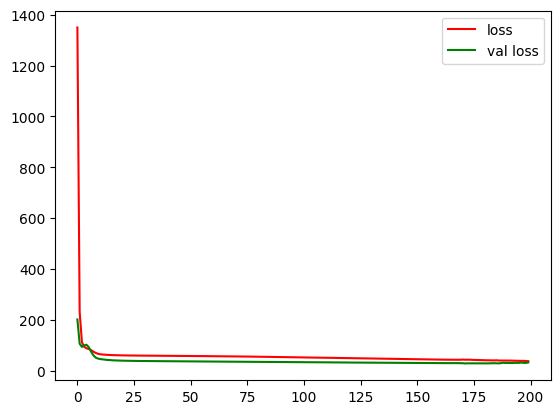

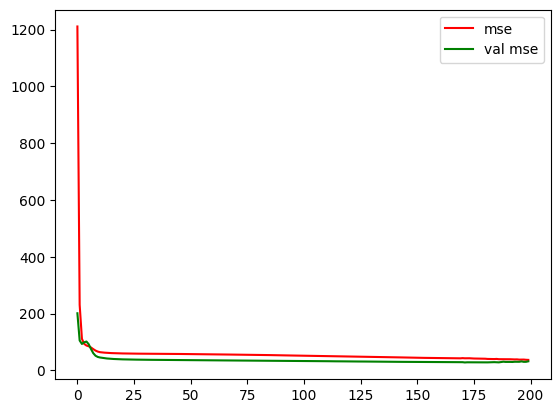

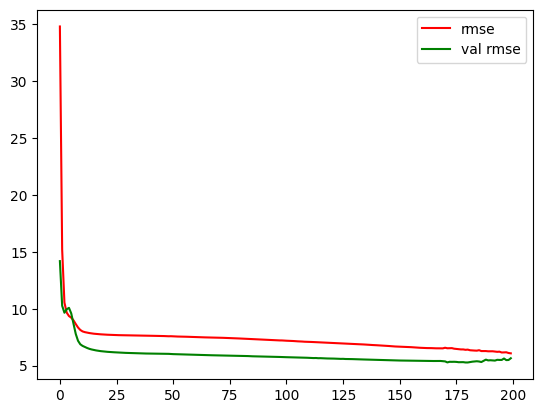

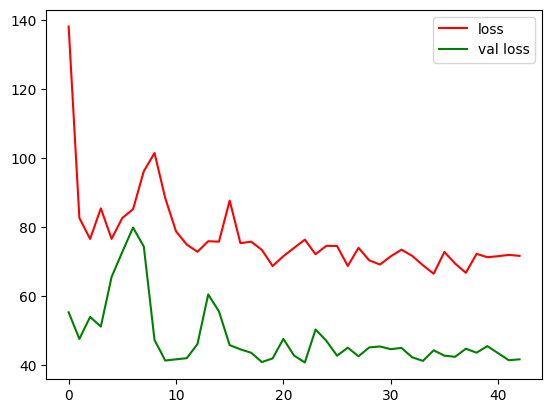

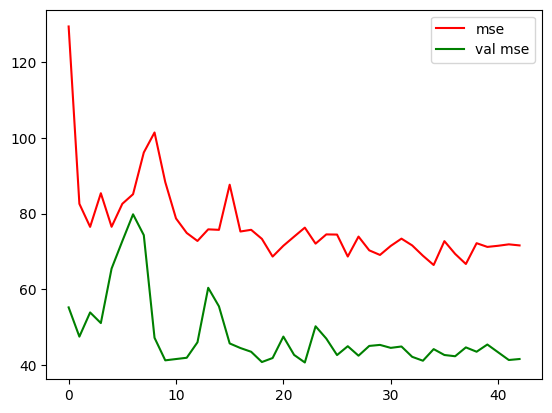

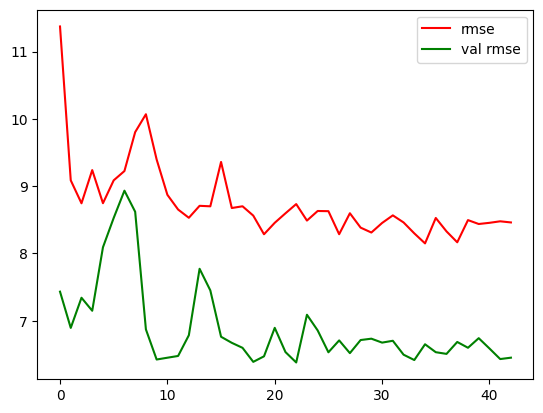

In [66]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [67]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [68]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2\regression.csv
Images shape:  (26, 26, 3)
Attributres:  13
Image size (pixels): 26


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5567.4766 - mae: 46.0060 - mse: 4040.6997 - r_square: -115.1846 - rmse: 62.4980 - val_loss: 521.9899 - val_mae: 21.4812 - val_mse: 521.9899 - val_r_square: -10.1271 - val_rmse: 22.8471
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 561.7604 - mae: 22.0310 - mse: 561.7604 - r_square: -7.6458 - rmse: 23.6860 - val_loss: 521.7805 - val_mae: 21.4764 - val_mse: 521.7805 - val_r_square: -10.1225 - val_rmse: 22.8425
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 561.5128 - mae: 22.0254 - mse: 561.5128 - r_square: -7.6418 - rmse: 23.6808 - val_loss: 521.4666 - val_mae: 21.4691 - val_mse: 521.4666 - val_r_square: -10.1155 - val_rmse: 22.8356
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 561.1761 - mae: 22.0178 - mse: 561.1761 - r_square: -7.6364 - rmse: 23.6737 - val_loss: 521.1031 - val_mae: 21.4606 - val_mse: 521.1031 - val_r_square: -10.1075 - val_rmse: 22.8277
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━

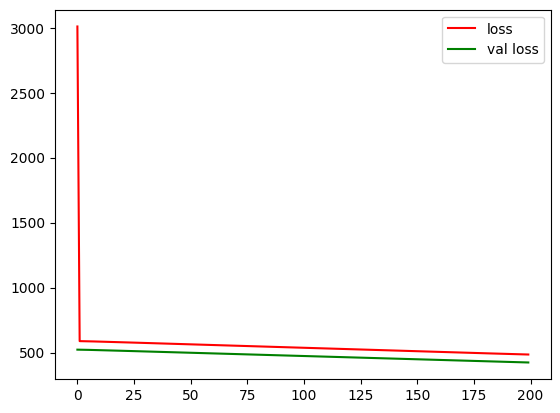

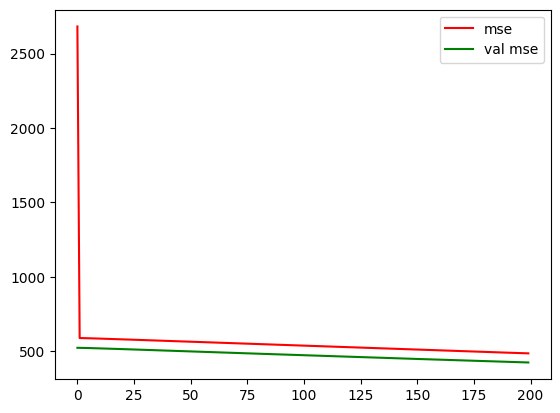

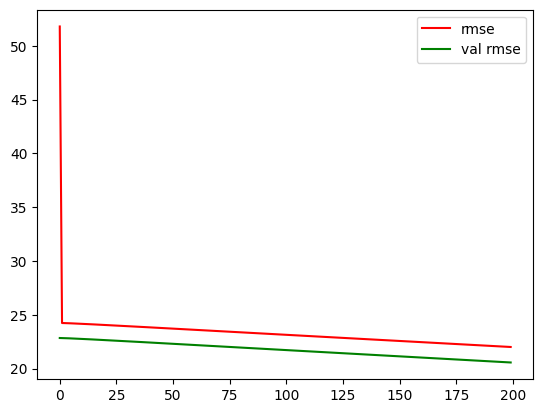

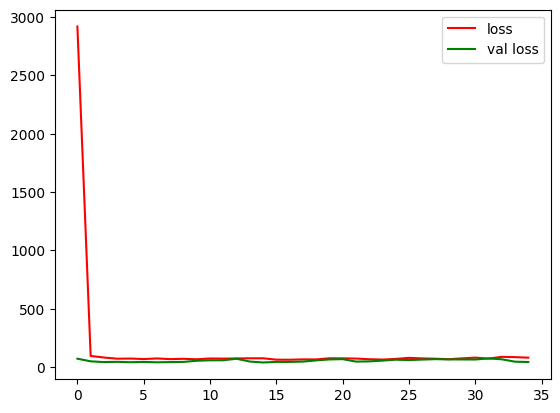

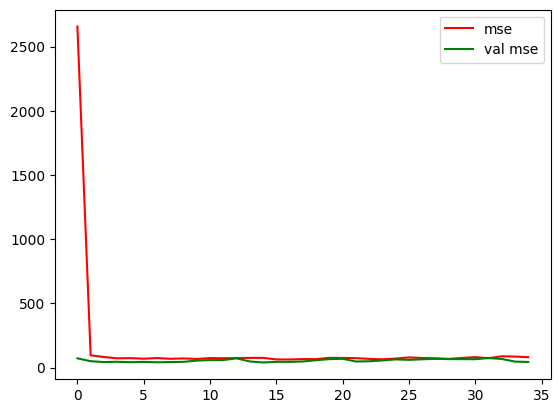

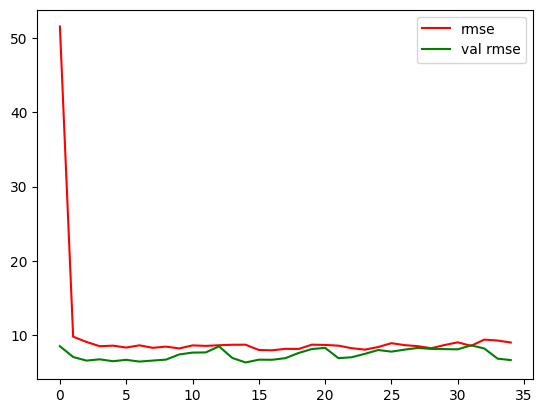

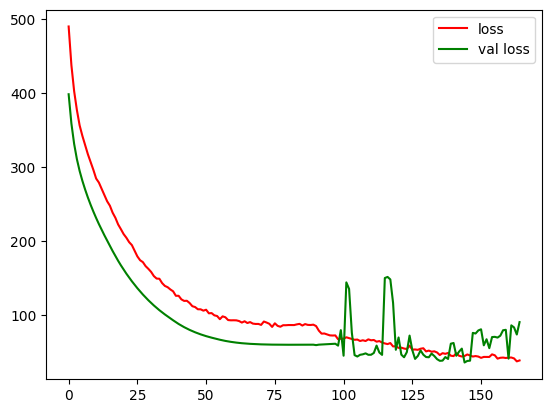

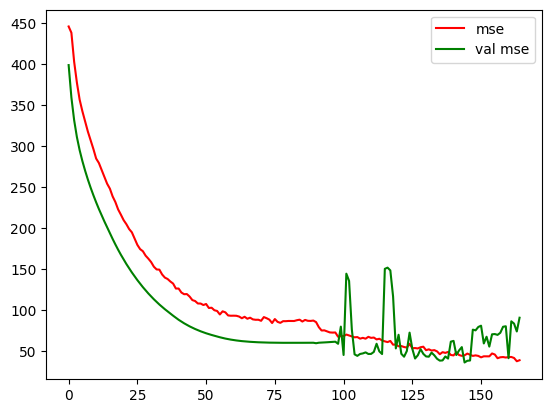

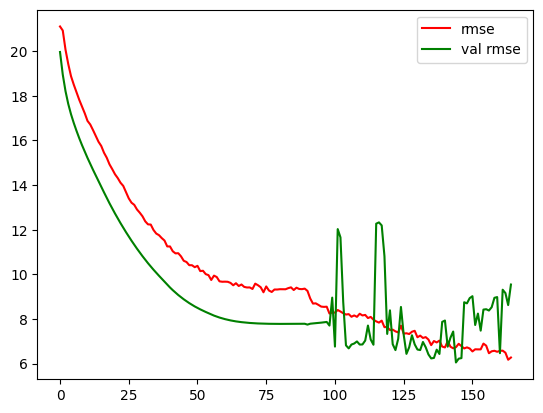

In [69]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [70]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [71]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4\regression.csv
Images shape:  (52, 52, 3)
Attributres:  13
Image size (pixels): 52


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 525557.2500 - mae: 273.6039 - mse: 386235.7188 - r_square: -13283.8242 - rmse: 586.0244 - val_loss: 521.7698 - val_mae: 21.4761 - val_mse: 521.7698 - val_r_square: -10.1223 - val_rmse: 22.8423
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.5508 - mae: 22.0263 - mse: 561.5508 - r_square: -7.6424 - rmse: 23.6816 - val_loss: 521.6815 - val_mae: 21.4741 - val_mse: 521.6815 - val_r_square: -10.1203 - val_rmse: 22.8403
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.4715 - mae: 22.0245 - mse: 561.4715 - r_square: -7.6411 - rmse: 23.6799 - val_loss: 521.6249 - val_mae: 21.4728 - val_mse: 521.6249 - val_r_square: -10.1190 - val_rmse: 22.8391
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.4155 - mae: 22.0232 - mse: 561.4155 - r_square: -7.6402 - rmse: 23.6787 - val_loss: 521.5729 - val_mae: 21.4715 - val_mse: 521.5729 - val_r_square: -10.1179 - val_rmse: 22.8380
Epoch 5/200
13/13 ━━━━━━━━━

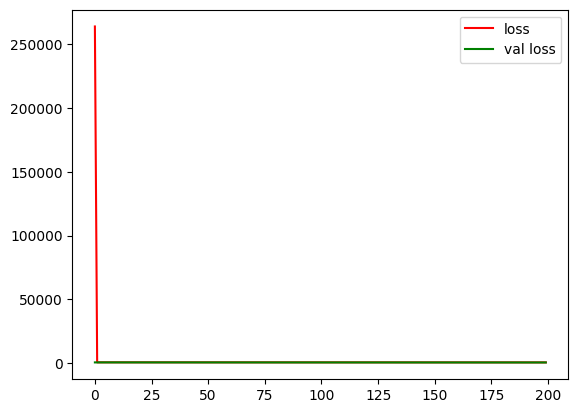

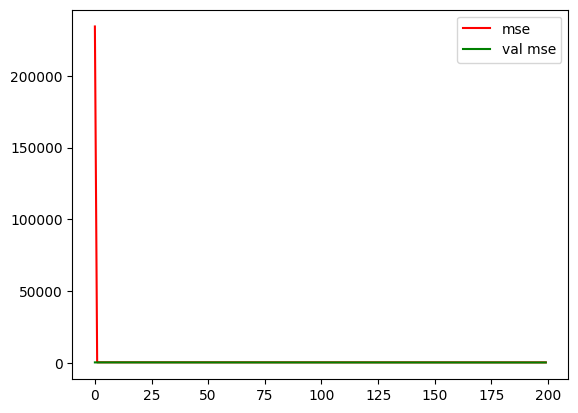

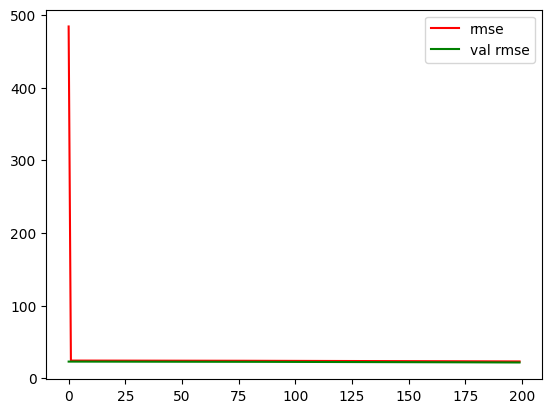

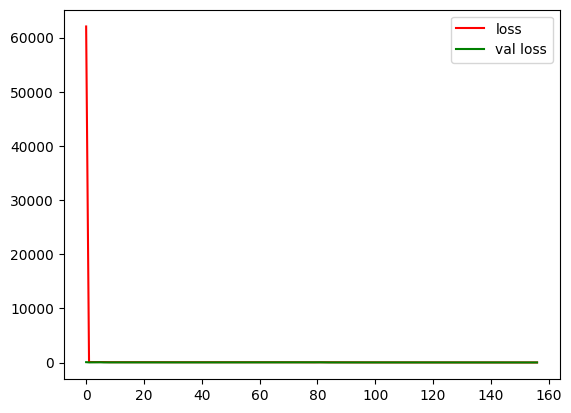

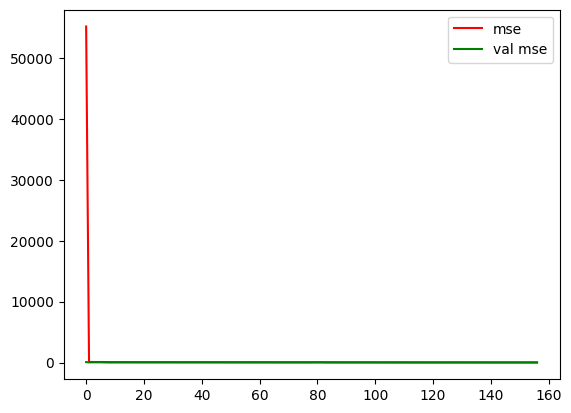

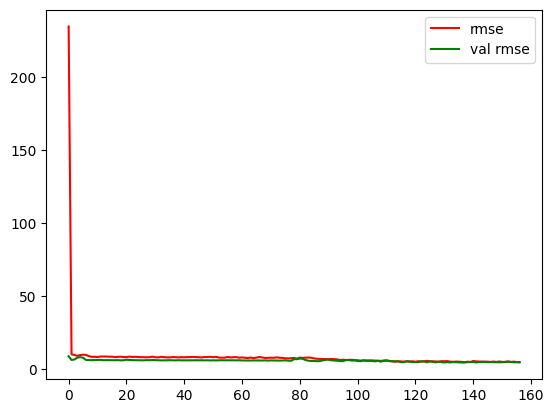

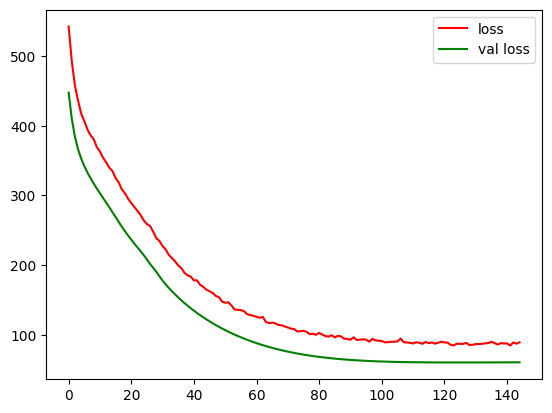

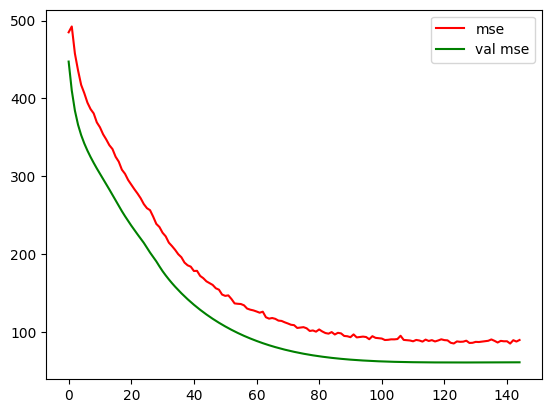

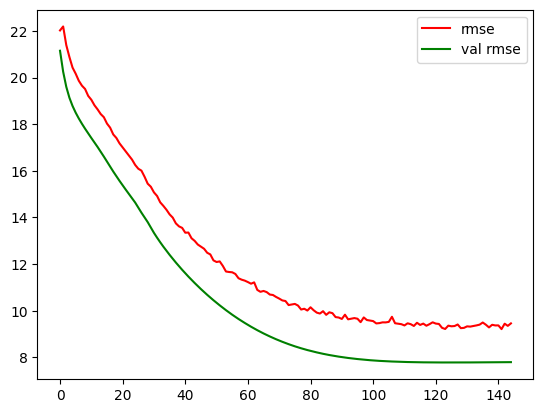

In [72]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 6: COMBINATION

In [73]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [74]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_Combination\regression.csv
Images shape:  (13, 13, 3)
Attributres:  13
Image size (pixels): 13


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 949.4099 - mae: 16.0120 - mse: 648.9877 - r_square: -9.2424 - rmse: 24.9483 - val_loss: 55.3376 - val_mae: 5.9314 - val_mse: 55.3376 - val_r_square: 0.0603 - val_rmse: 7.4389
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.1212 - mae: 4.9939 - mse: 47.1212 - r_square: 0.2951 - rmse: 6.8572 - val_loss: 32.7618 - val_mae: 4.5233 - val_mse: 32.7618 - val_r_square: 0.4282 - val_rmse: 5.7238
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.0927 - mae: 3.9900 - mse: 31.0927 - r_square: 0.5468 - rmse: 5.5670 - val_loss: 26.6773 - val_mae: 4.2631 - val_mse: 26.6773 - val_r_square: 0.5264 - val_rmse: 5.1650
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.4393 - mae: 3.6592 - mse: 24.4393 - r_square: 0.6425 - rmse: 4.9343 - val_loss: 22.3206 - val_mae: 3.8868 - val_mse: 22.3206 - val_r_square: 0.5777 - val_rmse: 4.7245
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.1613 - mae: 3.37

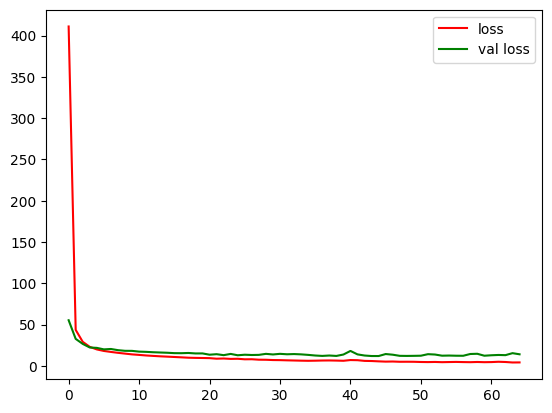

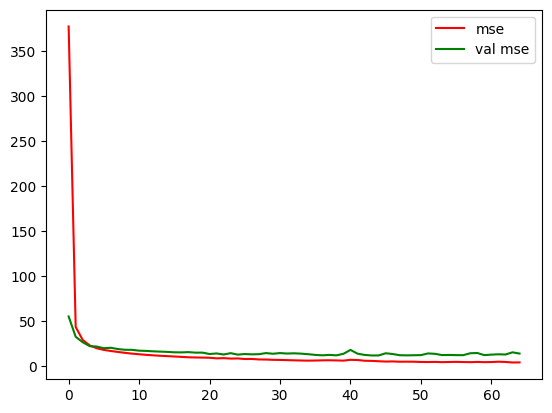

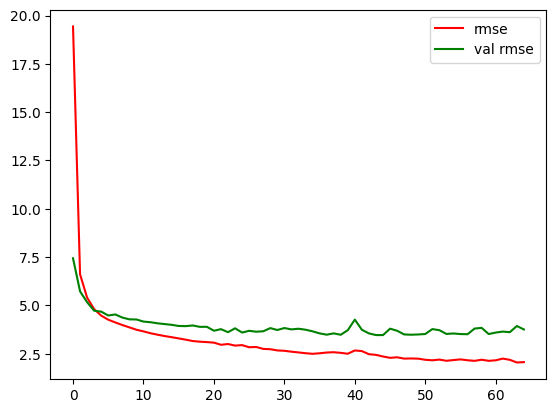

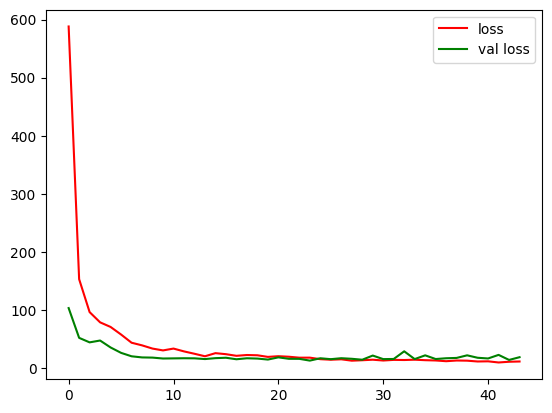

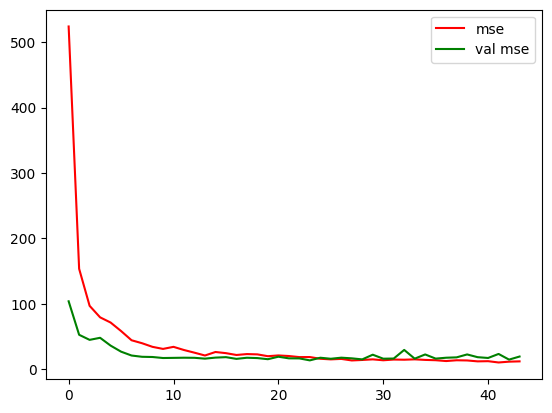

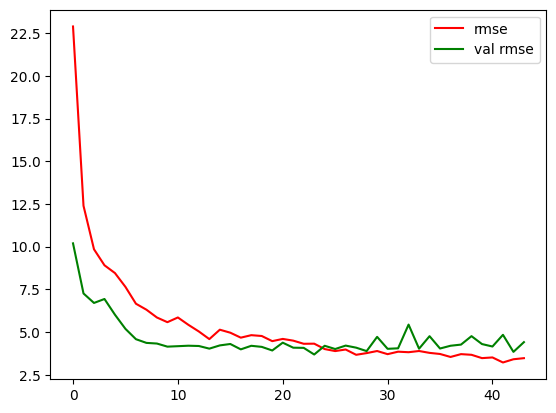

In [75]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [76]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [77]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_Combination_zoom2\regression.csv
Images shape:  (26, 26, 3)
Attributres:  13
Image size (pixels): 26


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 14068.0811 - mae: 60.6540 - mse: 10320.8730 - r_square: -337.2837 - rmse: 98.1690 - val_loss: 67.3253 - val_mae: 6.8873 - val_mse: 67.3253 - val_r_square: -0.3390 - val_rmse: 8.2052
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95.1083 - mae: 7.6903 - mse: 95.1083 - r_square: -0.4903 - rmse: 9.7028 - val_loss: 68.0320 - val_mae: 7.0519 - val_mse: 68.0320 - val_r_square: -0.4309 - val_rmse: 8.2481
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.1454 - mae: 5.6507 - mse: 52.1454 - r_square: 0.2253 - rmse: 7.2080 - val_loss: 55.9717 - val_mae: 6.5069 - val_mse: 55.9717 - val_r_square: -0.1996 - val_rmse: 7.4814
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.2484 - mae: 5.0469 - mse: 40.2484 - r_square: 0.4057 - rmse: 6.3172 - val_loss: 44.4782 - val_mae: 5.8023 - val_mse: 44.4782 - val_r_square: -0.0158 - val_rmse: 6.6692
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.0128 

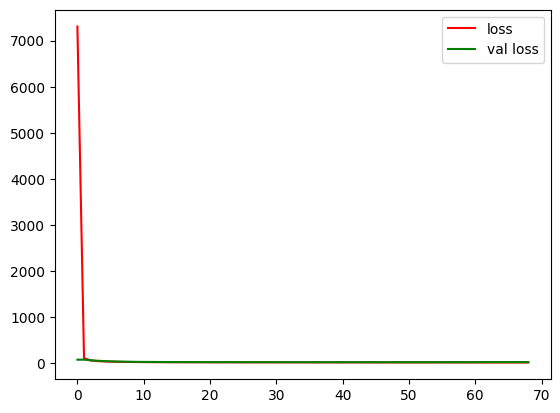

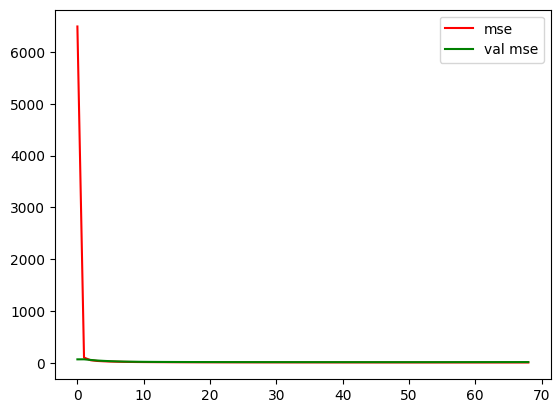

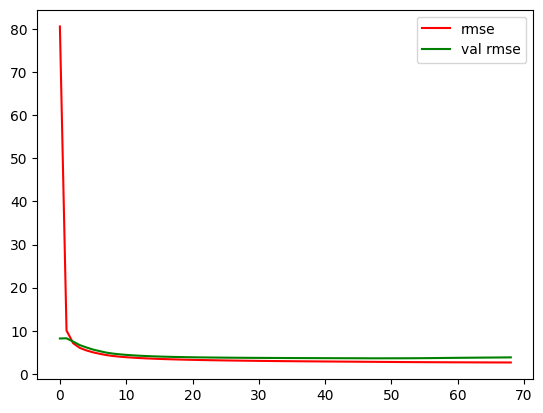

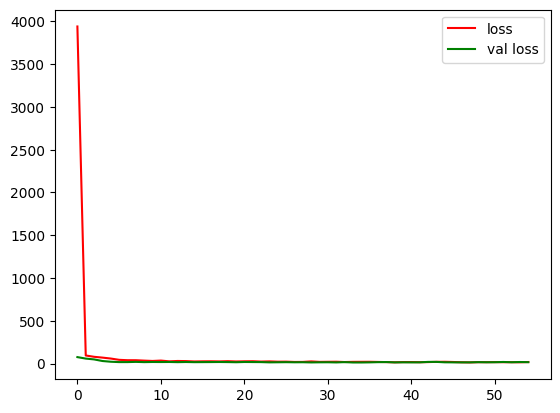

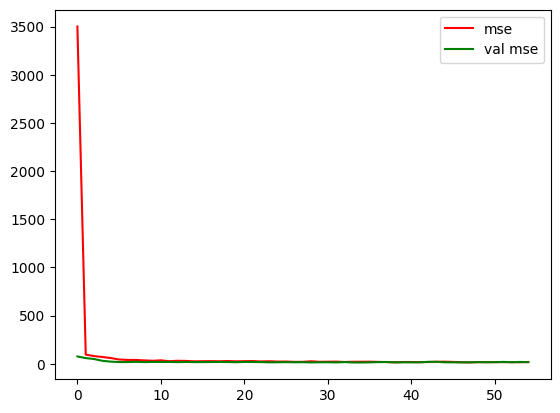

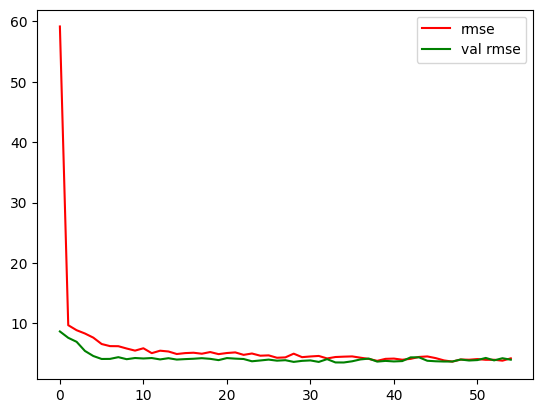

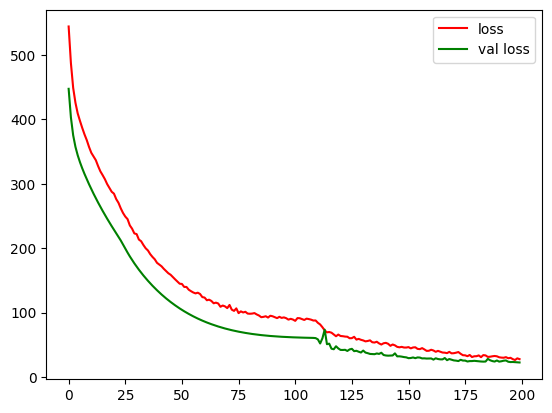

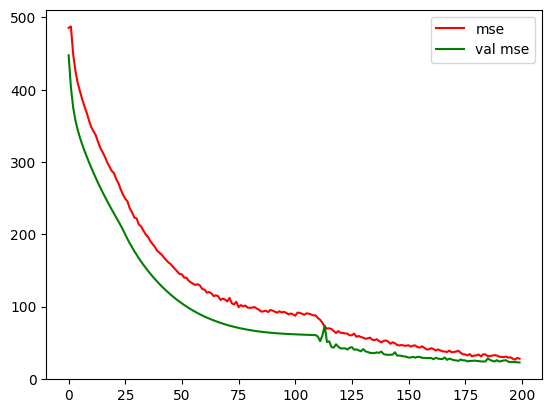

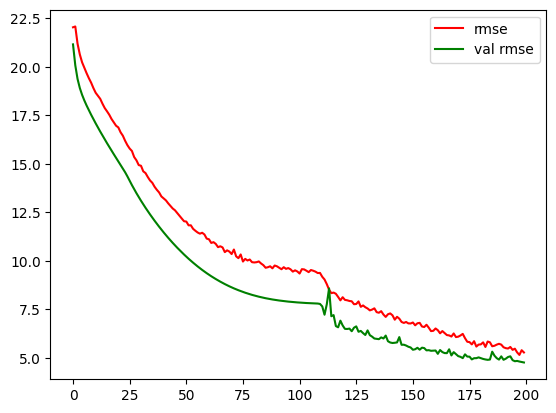

In [78]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [79]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [80]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_Combination_zoom4\regression.csv
Images shape:  (52, 52, 3)
Attributres:  13
Image size (pixels): 52


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 567398.6875 - mae: 278.7997 - mse: 416200.9062 - r_square: -14367.0215 - rmse: 609.1061 - val_loss: 522.1066 - val_mae: 21.4840 - val_mse: 522.1066 - val_r_square: -10.1297 - val_rmse: 22.8497
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.9355 - mae: 22.0350 - mse: 561.9355 - r_square: -7.6486 - rmse: 23.6897 - val_loss: 522.1351 - val_mae: 21.4846 - val_mse: 522.1351 - val_r_square: -10.1304 - val_rmse: 22.8503
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.9484 - mae: 22.0353 - mse: 561.9484 - r_square: -7.6488 - rmse: 23.6900 - val_loss: 522.1138 - val_mae: 21.4841 - val_mse: 522.1138 - val_r_square: -10.1299 - val_rmse: 22.8498
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 561.9207 - mae: 22.0347 - mse: 561.9207 - r_square: -7.6484 - rmse: 23.6894 - val_loss: 522.0734 - val_mae: 21.4832 - val_mse: 522.0734 - val_r_square: -10.1290 - val_rmse: 22.8489
Epoch 5/200
13/13 ━━━━━━━━━

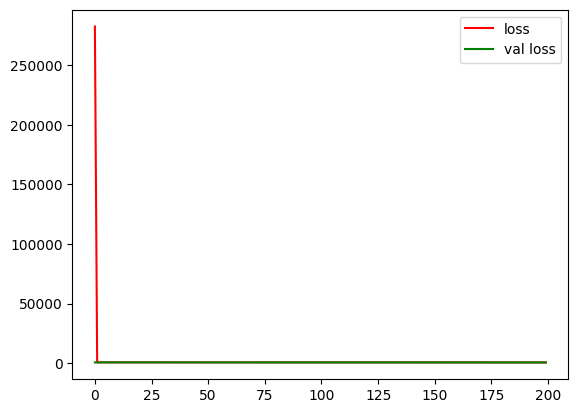

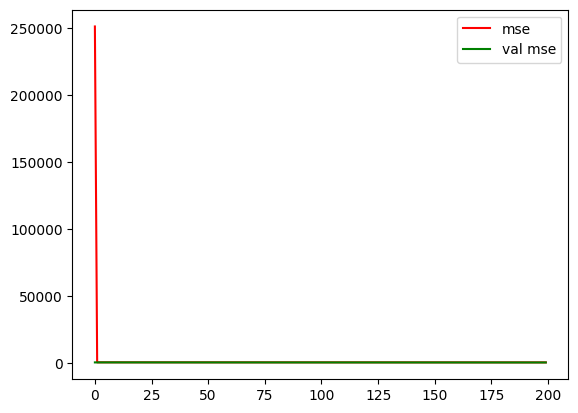

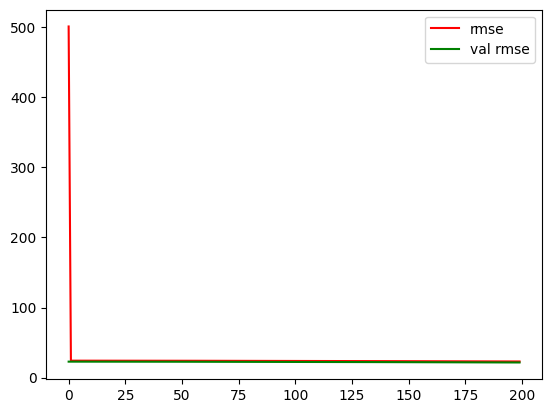

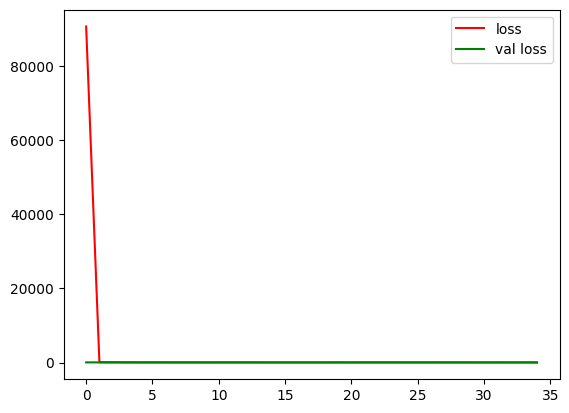

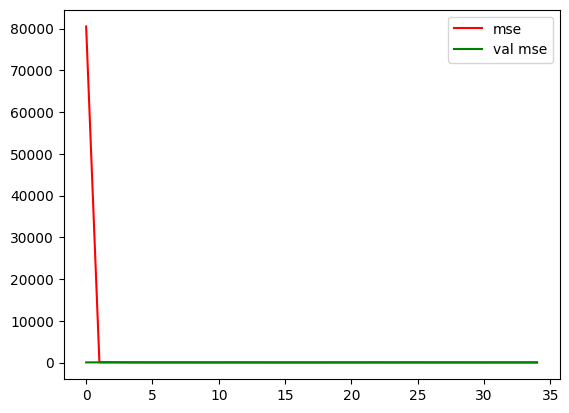

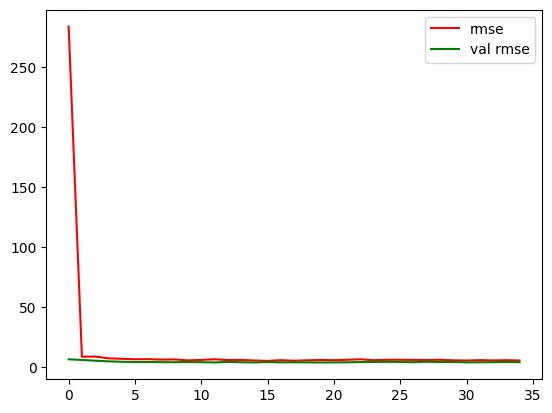

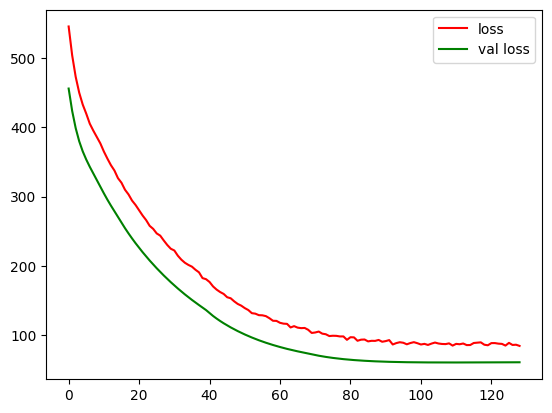

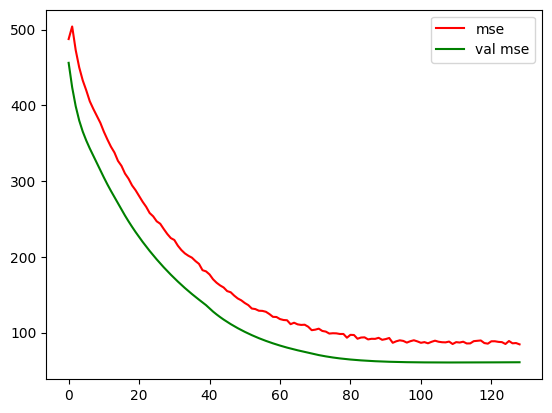

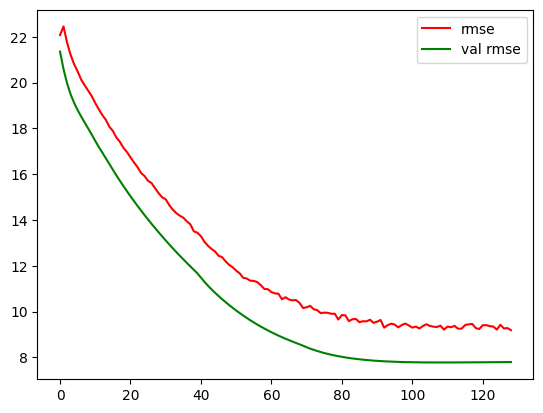

In [81]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

### EXPERIMENT 7: SUPERTML

In [82]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [83]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_SuperTML-EF\regression.csv
Images shape:  (224, 224, 3)
Attributres:  13
Image size (pixels): 224


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 427561.0312 - mae: 249.6207 - mse: 314095.0312 - r_square: -10697.1465 - rmse: 528.7963 - val_loss: 522.0148 - val_mae: 21.4818 - val_mse: 522.0148 - val_r_square: -10.1277 - val_rmse: 22.8476
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 561.8286 - mae: 22.0326 - mse: 561.8286 - r_square: -7.6469 - rmse: 23.6875 - val_loss: 522.0042 - val_mae: 21.4816 - val_mse: 522.0042 - val_r_square: -10.1275 - val_rmse: 22.8474
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 561.8094 - mae: 22.0321 - mse: 561.8094 - r_square: -7.6466 - rmse: 23.6870 - val_loss: 521.9670 - val_mae: 21.4807 - val_mse: 521.9670 - val_r_square: -10.1266 - val_rmse: 22.8466
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 561.7676 - mae: 22.0312 - mse: 561.7676 - r_square: -7.6459 - rmse: 23.6862 - val_loss: 521.9170 - val_mae: 21.4796 - val_mse: 521.9170 - val_r_square: -10.1255 - val_rmse: 22.8455
Epoch 5/200
13/13 ━━━━━━

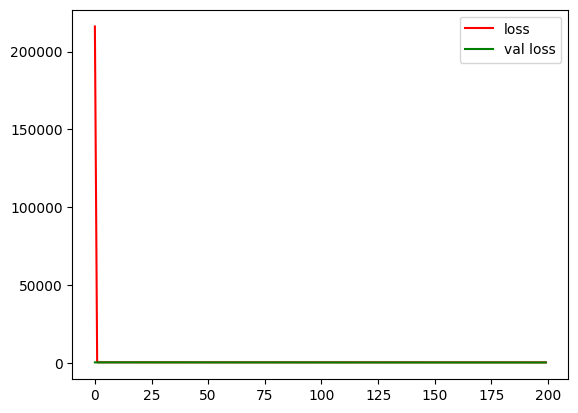

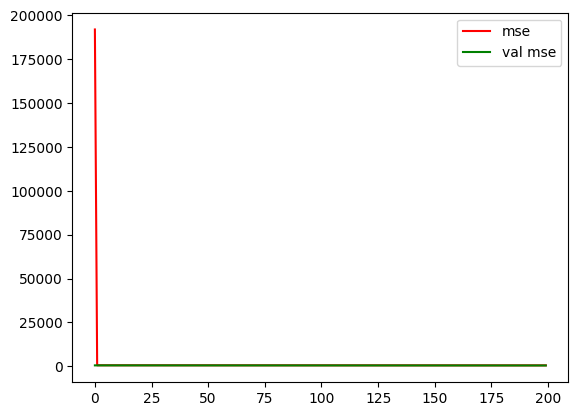

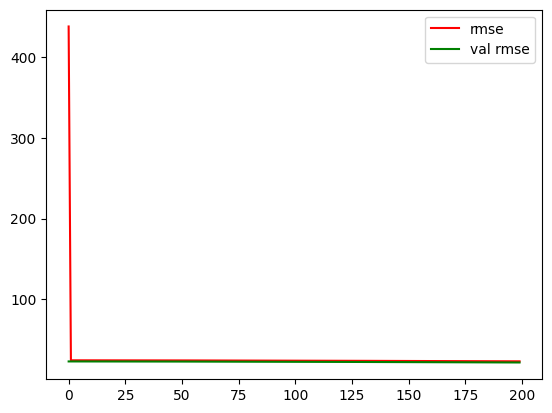

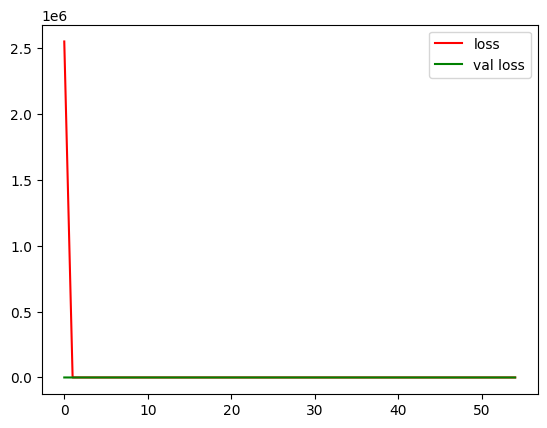

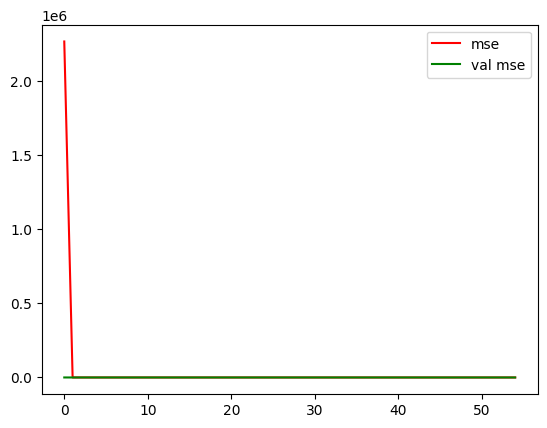

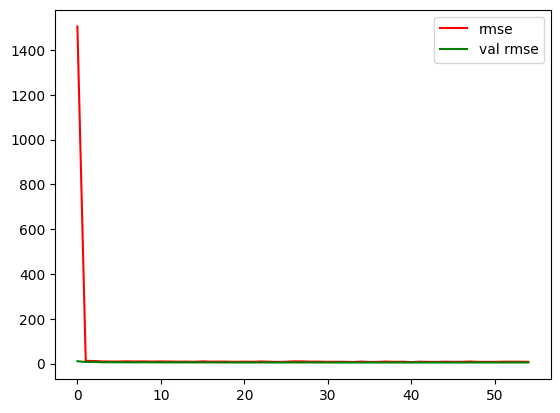

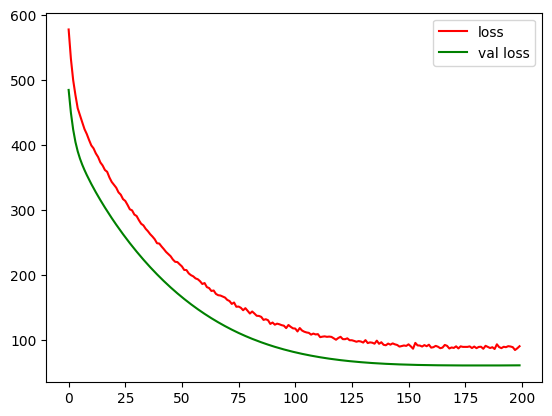

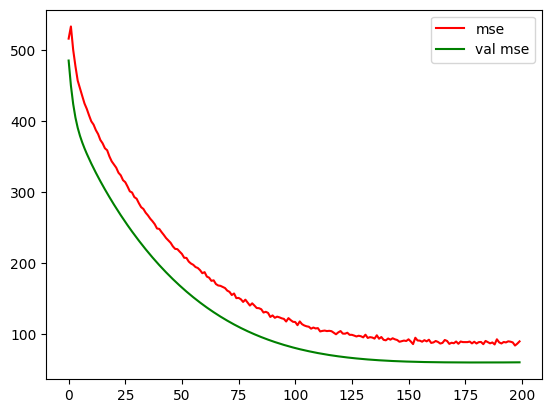

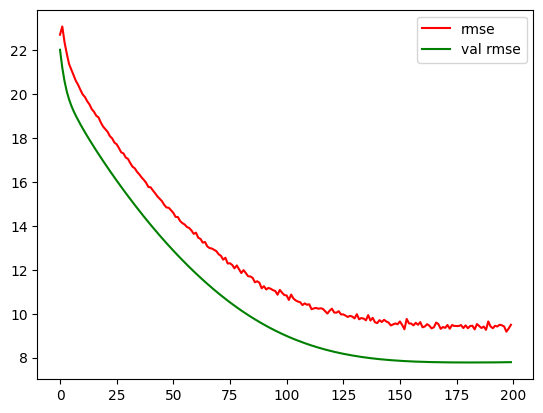

In [84]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

In [85]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [86]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

../HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30\regression.csv
Images shape:  (224, 224, 3)
Attributres:  13
Image size (pixels): 224


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 91536.2266 - mae: 109.3901 - mse: 67049.5000 - r_square: -2322.3394 - rmse: 244.4024 - val_loss: 70.8996 - val_mae: 7.2450 - val_mse: 70.8996 - val_r_square: -0.7989 - val_rmse: 8.4202
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 54.2785 - mae: 6.0070 - mse: 54.2785 - r_square: 0.1908 - rmse: 7.3469 - val_loss: 56.1497 - val_mae: 5.9754 - val_mse: 56.1497 - val_r_square: -0.3514 - val_rmse: 7.4933
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 39.3096 - mae: 5.0133 - mse: 39.3096 - r_square: 0.3599 - rmse: 6.2584 - val_loss: 38.3590 - val_mae: 5.2565 - val_mse: 38.3590 - val_r_square: 0.2016 - val_rmse: 6.1935
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 32.7689 - mae: 4.5837 - mse: 32.7689 - r_square: 0.4428 - rmse: 5.7199 - val_loss: 25.9465 - val_mae: 4.0673 - val_mse: 25.9465 - val_r_square: 0.5084 - val_rmse: 5.0938
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 26.9

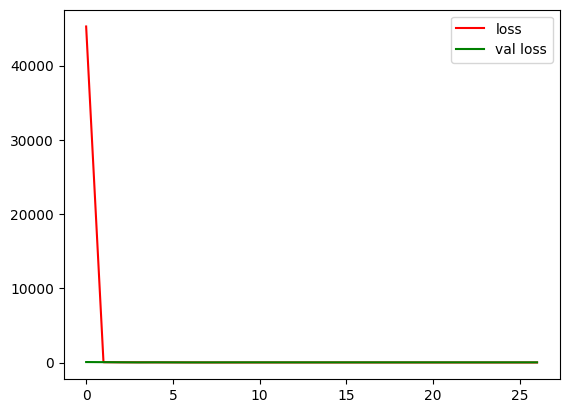

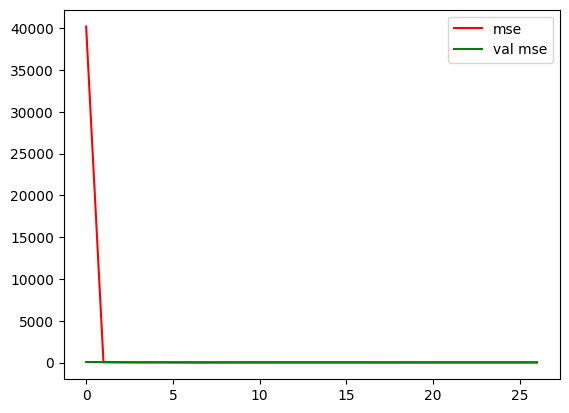

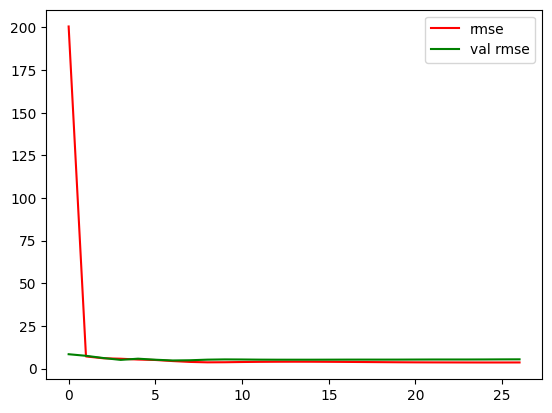

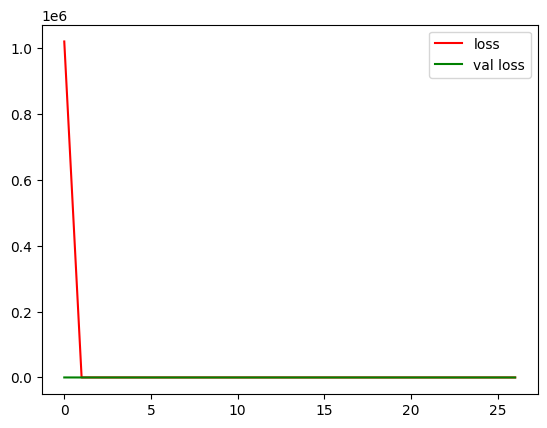

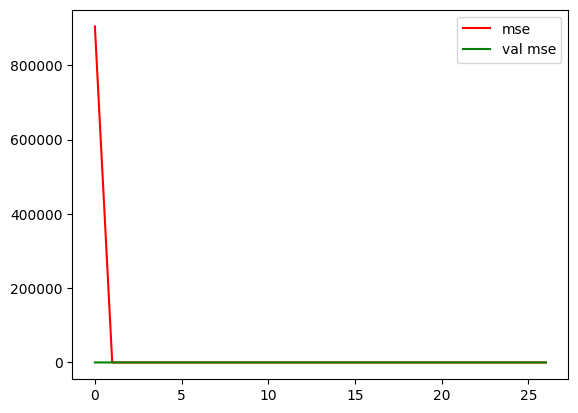

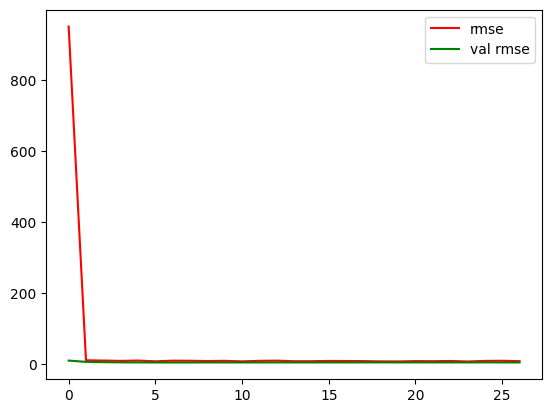

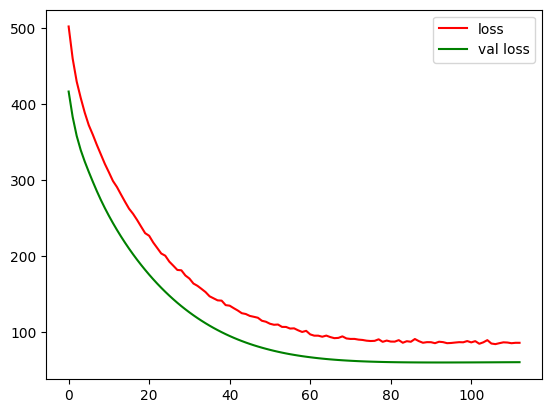

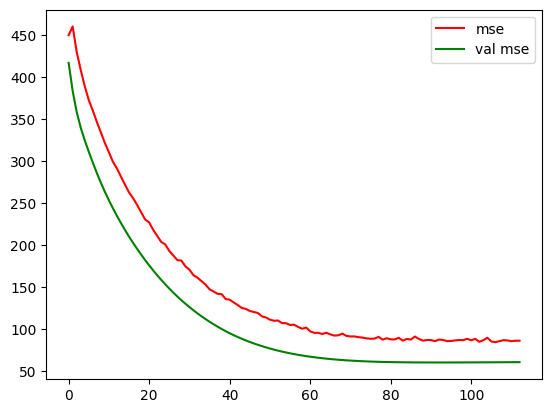

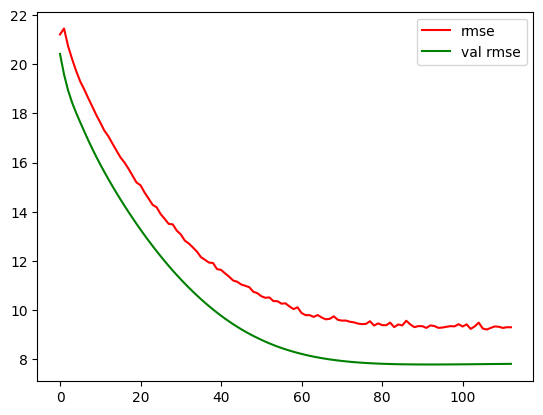

In [87]:
model1 = try_create_model(create_model1, imgs_shape)
model2 = try_create_model(create_model2, imgs_shape)
model3 = try_create_model(create_model3, imgs_shape)

# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model2")
model3_metrics = safe_compile_and_fit(model3, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, f"{name}_Model3")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)

## FINAL METRICS AND BEST MODEL

In [113]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'{dataset_name}_metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [114]:
import os

def rename_folder(old_folder_path):
    # Extract the base name of the old folder
    folder_name = os.path.basename(old_folder_path)
    
    # Create the new folder name by prepending "best_"
    new_folder_name = f"BEST_{folder_name}"
    
    # Get the parent directory of the old folder
    parent_dir = os.path.dirname(old_folder_path)
    
    # Create the full path for the new folder
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    
    # Rename the folder
    os.rename(old_folder_path, new_folder_path)
    
    return new_folder_path

In [115]:
# Usage
base_path = f"logs/{dataset_name}/CNN_Regression"
best_folder, best_rmse = find_best_model(base_path)
best_folder = rename_folder(best_folder)
print(f"Best model folder: {best_folder}")
print(f"Best RMSE: {best_rmse}")

Best model folder: logs/boston/CNN_Regression\BEST_Combination_zoom2_Model1
Best RMSE: 4.048828601837158
